In [1]:
# Imports
import sys,os,time,itertools,warnings,copy
from collections import *

# PyData Ecosystem
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import clone
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib.ticker import LinearLocator, FormatStrFormatter


# Miscellaneous
import ptitprince as pt
import gseapy as gp

# Soothsayer Ecosystem
import soothsayer as sy
from soothsayer.classification import HierarchicalClassifier as HEC
import hive_networkx as hx
import ensemble_networkx as enx
import compositional as coda

# ALDEx2
from soothsayer.utils import assert_acceptable_arguments
from soothsayer.r_wrappers import R_package_retrieve, pandas_to_rpy2, rpy2_to_pandas
import rpy2.robjects as ro


# Duration
start_time = time.time()
# ====================
# Soothsayer Ecosystem
# ====================
#  * Soothsayer v2021.07.27
#  * Soothsayer Utilities v2021.07.27
#  * Compositional v2020.12.16
#  * Hive NetworkX v2021.05.18
#  * Ensemble NetworkX v2021.06.24

%matplotlib inline


Soothsayer Ecosystem
 * Soothsayer v2021.07.27
 * Soothsayer Utilities v2021.07.27
 * Compositional v2020.12.16
 * Hive NetworkX v2021.05.18
 * Ensemble NetworkX v2021.06.24


In [2]:
# Utility functions
def plot_distribution(df_data,
                      plot_type="box",
                      size=8,
                      color_fill="darkgray",
                      color_swarm=None,
                      color_density=None,
                      title=None,
                      xlabel=None,
                      ylabel="infer",
                      legend=False,
                      x_rot=90,
                      swarm=True,
                      bins=None,
                      hist=True,
                      rug=False,
                      shade=True,
                      figsize=(13,5),
                      ax=None,
                      style="seaborn-white",
                      fig_kws=dict(),
                      title_kws=dict(),
                      legend_kws=dict(),
                      distr_kws=dict(),
                      swarm_kws=dict(),
                      xtick_kws=dict(),
                      ytick_kws=dict(),
                      axis_kws=dict(),
                      annot_kws=dict(),

                      # Stats
                      show_n=False,
                      pairs=None,
                      stats_width=1,
                      stats_color="black",
                      stats_func=stats.mannwhitneyu,
                      precision=3,
                      stats_kws=dict(),
                      stats_offset=1,
                     ):
    """
    2018-July-2
    
    Future:
    * Make `df_data` -> `X`
    * Include `y` option that uses the hue feature
    * Make it use `kruskal-walis` test if there are 3 classes

    Bugs:
    No known bugs
    """
    supported_types = ["box", "violin", "density"]
    assert plot_type in supported_types, f"`plot_type` must be in {supported_types}"

    # DEFAULTS
    DEFAULT_PALETTE = "Set2"

    # Keywords
    _fig_kws = {"figsize":figsize}
    _fig_kws.update(fig_kws)
    _swarm_kws = {"edgecolor":"black", "linewidth":1}
    _swarm_kws.update(swarm_kws)
    _distr_kws = {}
    _distr_kws.update(distr_kws)
    if plot_type == "density":
        _xtick_kws = {"fontsize":15}
        _xtick_kws.update(xtick_kws)
        _ytick_kws = {"fontsize":15}
        _ytick_kws.update(ytick_kws)
    else:
        _xtick_kws = {"fontsize":15, "rotation":x_rot}
        _xtick_kws.update(xtick_kws)
        _ytick_kws = {"fontsize":12}
        _ytick_kws.update(ytick_kws)
    _axis_kws = {"fontsize":15}
    _axis_kws.update(axis_kws)
    _title_kws = {"fontsize":18, "fontweight":"bold"}
    _title_kws.update(title_kws)
    _legend_kws = {'fontsize': 15, 'frameon': True, 'facecolor': 'white', 'edgecolor': 'black', 'loc': 'center left', 'bbox_to_anchor': (1, 0.5)}
    _legend_kws.update(legend_kws)
    _annot_kws = dict(ha='center', va='bottom', fontsize=15) #
    _annot_kws.update(annot_kws)
    _stats_kws=dict(ha='center', va='bottom', color=stats_color, fontsize=15) # ax.text (stats)
    _stats_kws.update(stats_kws)

    # Functions
    def _process_colors(df_data, colors, DEFAULT_PALETTE=DEFAULT_PALETTE):
        if type(colors) == sns.palettes._ColorPalette:
            return colors
        if colors is None:
            return sns.color_palette(palette=DEFAULT_PALETTE, n_colors=df_data.shape[1])

        try:
            return sns.color_palette(palette=colors, n_colors=df_data.shape[1])
        except ValueError:
            is_list_like = lambda x: hasattr(x, '__iter__') and not type(x) == str
            color_missing = "gray"
            if mpl.colors.is_color_like(colors):
                colors = [colors]*df_data.columns.size
            else:
                condition_A = type(colors) == pd.Series
                condition_B = isinstance(colors, (dict, OrderedDict))
                if any([condition_A, condition_B]):
                    colors = df_data.columns.map(lambda x: colors[x] if x in colors else color_missing).tolist()
                condition_C = is_list_like(colors)
                if not condition_C:
                    print(f"Warning: Incorrect colors `{colors}`", file=sys.stderr)
                    colors = [color_missing]*df_data.shape[1]
            return sns.color_palette(palette=colors)


    def _plot_vertical_distribution(df_data, kind, swarm, palette_fill, palette_swarm, distr_kws, swarm_kws, xtick_kws, ytick_kws, ax):
        df_melt = pd.melt(df_data, var_name="variable").dropna(how="any", axis=0).reset_index()
        if plot_type == "box":
            sns.boxplot(data=df_melt, x="variable", y="value", palette=palette_fill, ax=ax, **distr_kws)
        if plot_type == "violin":
            sns.violinplot(data=df_melt, x="variable", y="value",palette=palette_fill, ax=ax, **distr_kws)
        if swarm:
            sns.swarmplot(data=df_melt, x="variable", y="value", size=size, palette=palette_swarm, ax=ax, **swarm_kws)
        ax.set_xticklabels(ax.get_xticklabels(), **xtick_kws)
        ax.set_yticklabels(ax.get_yticks(), **ytick_kws)
        ax.set_xlabel("")
        ax.set_ylabel("")

    def _plot_horizontal_distribution(df_data, bins, rug, shade, palette_density, distr_kws, xtick_kws, ytick_kws, ax):
        for (name, vector), color in zip(df_data.T.iterrows(), palette_density):
            sns.distplot(vector.dropna().values, color=None, hist=hist, rug=rug, kde_kws={"shade":shade}, ax=ax)
        ax.set_xticklabels(ax.get_xticks(), **xtick_kws)
        ax.set_yticklabels(ax.get_yticks(), **ytick_kws)

    def _plot_stats(df_data, pairs, stats_offset, precision, stats_func, stats_color, stats_width, annot_kws, stats_kws):
        stats_offset = max(stats_offset,1e-5)
        # Statistical tests
        x = df_data.values.ravel()
        x = x[np.isfinite(x)]
        pad_y = (x.max() - x.min())*5e-2
        if show_n:
            for j in range(df_data.shape[1]):
                u = df_data.iloc[:,j].dropna()
                ax.text(x=j, y=u.median() + pad_y*5e-1, s="n=%d"%u.size, **annot_kws)
        for i, pair in enumerate(pairs):
            element_A, element_B = pair
            if all(x in df_data.columns for x in pair):
                # Vectors
                u = df_data[element_A].dropna()
                v = df_data[element_B].dropna()
                # Index positions
                x_A, x_B = map(df_data.columns.get_loc, pair)
                # Set up bar positions
                y, h = u.max() + pad_y, pad_y
                y += i/stats_offset
                # Plot statistics
                p_value = to_precision(stats_func(u,v)[1], precision=precision)
                ax.plot([x_A, x_A, x_B, x_B], [y, y+h, y+h, y], linewidth=stats_width, c=stats_color)
                ax.text((x_A + x_B)*0.5, y+h + 1e-2, p_value, **stats_kws)
            else:
                print(f"Error: {pair} not in input columns", file=sys.stderr)


    # Format colors
    palette_fill = _process_colors(df_data, color_fill)
    palette_swarm = _process_colors(df_data, color_swarm)
    palette_density = _process_colors(df_data, color_density)

    # Labels
    if ylabel == "infer":
        if plot_type == "density":
            ylabel = "Density"
        else:
            ylabel = None

    # Plot controller
    with plt.style.context(style):
        if ax is None:
            fig, ax = plt.subplots(**_fig_kws)
        if plot_type == "density":
            _plot_horizontal_distribution(df_data, bins=bins, rug=rug, shade=shade, palette_density=palette_density, distr_kws=_distr_kws, xtick_kws=_xtick_kws, ytick_kws=_ytick_kws, ax=ax)
        else:
            _plot_vertical_distribution(df_data, kind=plot_type, swarm=swarm, palette_fill=palette_fill, palette_swarm=palette_swarm, distr_kws=_distr_kws, swarm_kws=_swarm_kws, xtick_kws=_xtick_kws, ytick_kws=_ytick_kws, ax=ax)
            if pairs is not None:
                _plot_stats(df_data, stats_offset=stats_offset, precision=precision, pairs=pairs, stats_kws=_stats_kws, annot_kws=_annot_kws, stats_func=stats_func, stats_color=stats_color, stats_width=stats_width)
                ylim = ax.get_ylim()
                ax.set_ylim((ylim[0], ylim[1] + 0.05*ylim[1]))

        if title:
            ax.set_title(title, **_title_kws)
        if xlabel:
            ax.set_xlabel(xlabel, **_axis_kws)
        if ylabel:
            ax.set_ylabel(ylabel, **_axis_kws)

        if legend is not None:
            if legend is not False:
                if legend == True:
                    if plot_type == "density":
                        legend = dict(zip(df_data.columns, palette_density))
                    else:
                        legend = dict(zip(df_data.columns, palette_swarm))
                else:
                    legend = dict(legend)
                ax.legend(*legend_vars(legend), **_legend_kws)

    return ax

# Determine number of stars for statistical significance
def statistically_significant_symbols(p, mode=1, not_significant="ns"):
    # Symbol
    # Meaning
    # ns
    # P > 0.05
    # *
    # P ≤ 0.05
    # **
    # P ≤ 0.01
    # ***
    # P ≤ 0.001
    # ****
    #  P ≤ 0.0001 (For the last two choices only)
    if mode == 0:
        if p > 0.05:
            return not_significant
        symbol = ""
        if p <= 0.05:
            symbol += "*"
        if p <= 0.01:
            symbol += "*"
        if p <= 0.001:
            symbol += "*"
        if p <= 0.0001:
            symbol += "*"
        return symbol
    if mode == 1:
        return pd.Series(p).map(lambda x:statistically_significant_symbols(x, mode=0, not_significant=not_significant))
    
# Majority voting
def majority_voting(X_te, model, grouping=None, mode="soft", label_inconclusive="INCONCLUSIVE"):
    """
    Future: Add this to HierarchicalClassifier
    """
    accepted_modes = ["soft", "hard"]
    assert mode in accepted_modes, f"mode must be one of the following: {accepted_modes}"
    if grouping is None:
        prediction = None
        # Soft voting
        if mode == "soft":
            Y_hat = model.predict_proba(X_te )
            prediction = model.predict_from_probas(Y_hat.mean(axis=0))
        # Hard voting
        if mode == "hard":
            y_hat = model.predict(X_te )
            y_hat_valuecounts = y_hat.value_counts()
            y_hat_valuecounts_max = y_hat_valuecounts.max()
            if y_hat_valuecounts_max > 1:
                # Check to see if the maximum is unique.  If it isn't then flag as inconclusive
                if y_hat_valuecounts[lambda x: x == y_hat_valuecounts_max].size > 1:
                    prediction = label_inconclusive
                else:
                    prediction = y_hat_valuecounts.idxmax()
            else:
                prediction = label_inconclusive
        assert prediction is not None, "Please check function for error.  `prediction` should not be None at this point."
        return prediction
    else:            
        d_group_prediction = dict()
        for group, X_group in X_te.groupby(grouping, axis=0):
            d_group_prediction[group] = majority_voting(X_group, model, grouping=None, mode=mode, label_inconclusive=label_inconclusive)
        return pd.Series(d_group_prediction, name=mode)
    
    


In [3]:
# Metadata
df_meta_samples = sy.io.read_dataframe("./Data/sample_metadata.tsv") # Just a high-level wrapper around `pd.read_csv`
df_meta_samples.index.name = "LibraryID"
old_to_new = df_meta_samples["SampleID(Alias)"].copy()
df_meta_samples = df_meta_samples.reset_index().set_index("SampleID(Alias)")

# Colors
colors_status = sy.Chromatic.from_classes(df_meta_samples["Nutritional_Status"], name="Nutritional_Status", class_type="status", obsv_type="sample", palette="Set2")

df_meta_samples.head()

,LibraryID,SampleID,Sex,Age[Months],Age[Days],Visit[Day],Date_Collected,SubjectID,Weight,Height,Nutritional_Status,WHZ,SubjectID(Alias)
SampleID(Alias),,,,,,,,,,,,,
C-01_V-00,HRG001M_S39,HRG001M,F,15.47,464,0,2013-06-04,HRG001M,6.24,73.04,SAM,-3.94,C-01
C-01_V-14,HRG001M_S19,HRG001M,F,16.00,480,14,2013-06-20,HRG001M,6.72,75.53,SAM,-3.70,C-01
C-01_V-28,HRG001M_S41,HRG001M,F,16.47,494,28,2013-07-04,HRG001M,6.77,76.73,SAM,-3.88,C-01
C-02_V-00,HRG002Y_S59,HRG002V,F,12.87,386,0,2013-06-07,HRG002Y,7.46,70.47,WN,-1.14,C-02
C-03_V-00,HRG003E_S40,HRG003E,M,10.57,317,0,2013-06-11,HRG003E,6.82,71.02,SAM,-3.01,C-03


## Loadings in sample metadata and gut microbiome

In [4]:

# Load OTUs
ds_otus = sy.Dataset(
    data=sy.io.read_dataframe("./Data/otus.counts.filtered.tsv.gz", func_index=lambda x: old_to_new[x]),
    metadata_observations=df_meta_samples,
    metadata_target_field="Nutritional_Status",
    metadata_attributes=sy.io.read_dataframe("./Data/otus.qfilter.EE0.2.curated_SILVA_123_SSURef_Nr99_tax_silva.wang.qiime_format.filtered.taxonomy.tsv"),
    obsv_type="sample",
    attr_type="OTU",
    description="SILVA_123_SSURef_Nr99_tax_silva",
    name="Gut Microbiome",

)
print("Current default: {} {}".format(ds_otus.X_version, ds_otus.X.shape))

# Load 16S newick tree
import ete3
tree = ete3.Tree("./Data/otus.centroid.filtered.msa.nw")
try:
    tree_16s = sy.utils.name_tree_nodes(tree, node_prefix="y")
except Exception:
    tree.resolve_polytomy()
    tree_16s = sy.utils.name_tree_nodes(tree, node_prefix="y")



Current default: None (113, 388)


OTU (107, 388) | Life (107, 1) | Domain (107, 1) | Phylum (107, 15) | Class (107, 28) | Order (107, 40) | Family (107, 63) | Genus (107, 164) | Species (107, 227)
Current default: ('QC(samples)', ('prevalence', 13)) (107, 155)


/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/compositional/compositional.py:193: UserWarning: N=1 zeros detected in `X`.  Masking zeros as NaN and will default to nan-robust functions if 'mean' or 'median' were provided for centroid
  warnings.warn("N={} zeros detected in `X`.  Masking zeros as NaN and will default to nan-robust functions if 'mean' or 'median' were provided for centroid".format(n_zeros))


Dataset| Gut Microbiome | (113, 388)
        obsv_type: sample
        attr_type: OTU
        metric_type: None
        description: SILVA_123_SSURef_Nr99_tax_silva
datasets: [None, 'QC(samples)', ('QC(samples)', ('prevalence', 13)), ('QC(samples)', ('prevalence', 13), 'clr'), ('QC(samples)', ('prevalence', 13), 'clr', 'zscore')]
attribute_subsets: [None]
observation_subsets: [None]
        metadata_observations: 13
        metadata_attributes: 10
        default: ('QC(samples)', ('prevalence', 13)) | (107, 155)
        2021-10-25 20:26:16

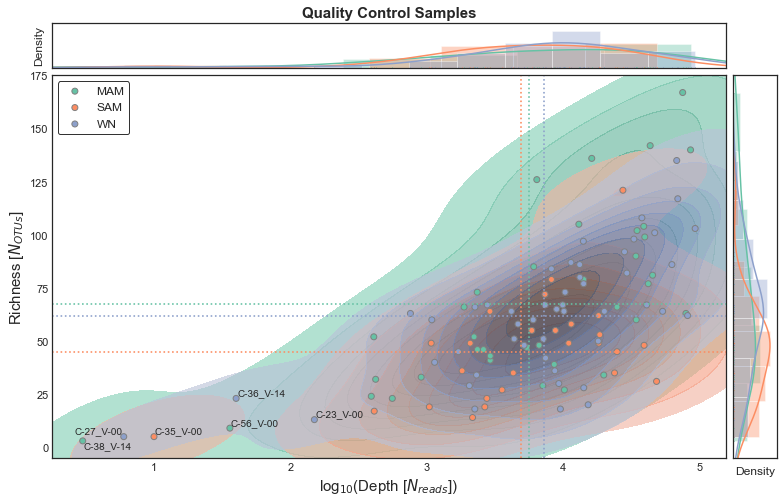

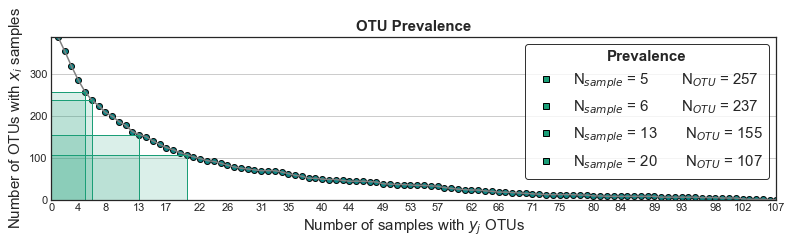

In [5]:
# Removing low quality samples
idx_samples_poorqc = ds_otus[None].sum(axis=1).sort_values().index[:6] # ds_otus[None] is the original counts table used to build the Dataset
with sy.Suppress():
    sy.visuals.plot_compositional(X=ds_otus[None], y=ds_otus.y, class_colors=colors_status.class_colors, show_annotations=idx_samples_poorqc, attr_type="OTU", show_ygrid=False, style="seaborn-white", background_color="white", title="Quality Control Samples")
y_phenotype = df_meta_samples["Nutritional_Status"].drop(idx_samples_poorqc)

# Add versions
# QC of samples
ds_otus.add_version("QC(samples)", ds_otus[None].drop(idx_samples_poorqc))
# QC of samples, remove OTUS in fewer than 13 samples
ds_otus.add_version(("QC(samples)", ("prevalence",13)), data=sy.utils.filter_compositional(ds_otus["QC(samples)"], tol_prevalence=13))
# QC of samples, remove OTUS in fewer than 13 samples, CLR normalization
ds_otus.add_version(("QC(samples)", ("prevalence",13),  "clr"), data=sy.transmute.transform_clr(ds_otus[("QC(samples)", ("prevalence",13))]))
# QC of samples, remove OTUS in fewer than 13 samples, CLR normalization, Z-score normalization for multimodal associations
ds_otus.add_version(("QC(samples)", ("prevalence",13),  "clr", "zscore"), data=sy.transmute.normalize(ds_otus[("QC(samples)", ("prevalence",13),  "clr")], "zscore", axis=0))
# Set default version
ds_otus.set_default(("QC(samples)", ("prevalence", 13)))

# Counts of OTUs at various taxonomy levels
taxonomy_counts = dict()
taxonomy_counts["OTU"] = ds_otus["QC(samples)"]
taxonomy_counts.update(dict(map(lambda x: (x, taxonomy_counts["OTU"].groupby(ds_otus.metadata_attributes[x], axis=1).sum()), ['Life', 'Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'])))
print(*map(lambda x: "{} {}".format(x[0], x[1].shape), taxonomy_counts.items()), sep=" | ")

# Prevalence of OTUs
sy.visuals.plot_prevalence(taxonomy_counts["OTU"], attr_type="OTU", obsv_type="sample", title="OTU Prevalence", show_prevalence=[5,6,13, 20], figsize=(13,3), title_kws={"fontsize":15})

# Reset the colors
colors_status = sy.Chromatic.from_classes(df_meta_samples.drop(idx_samples_poorqc)["Nutritional_Status"], name="Nutritional_Status", class_type="status", obsv_type="sample", palette="Set2")

print("Current default: {} {}".format(ds_otus.X_version, ds_otus.X.shape))
ds_otus

## Cycle thresholds [16S Amplicons]

/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level

MAM 22.46150016784668
SAM 30.520000457763672
WN 25.36849975585938


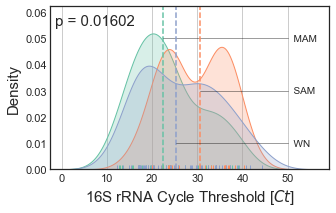

In [6]:

# Cycle thresholds
ct_16s = sy.io.read_dataframe("./Data/cycle_thresholds.16s.tsv", func_index=lambda x: old_to_new[x])["16S[Ct]"]

positions = [0.05, 0.03, 0.01]

with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(5,3))
    data = list()
    for i, (id_status, u) in enumerate(ct_16s.groupby(ds_otus.y)):
        sns.distplot(u, color=colors_status.class_colors[id_status], rug=True, ax=ax, kde_kws={"shade":True}, hist=False)#, label="µ = %0.3f"%u.median())
        ax.axvline(u.median(), color=colors_status.class_colors[id_status], linestyle="--")
        ax.set_xlabel("16S rRNA Cycle Threshold [$Ct$]", fontsize=15)
        ax.set_ylabel("Density", fontsize=15)
        ax.xaxis.grid(True)
        data.append(u)
        med = u.median()
        ax.text(x=50, y=positions[i], s="  {}".format(id_status), va="center", ha="left")
        ax.plot([med,50], [positions[i],positions[i]], color="black", alpha=0.6180, linestyle="-", linewidth=0.618)
        print(id_status, u.median())
    stat, p = stats.kruskal(*data)

    ax.text(min(ax.get_xlim())+1, max(ax.get_ylim())*0.95, "p = %0.5f"%p, ha="left", va="top", fontsize=15)
#     ax.legend(*sy.utils.format_mpl_legend_handles(colors_status.class_colors[["WN", "MAM", "SAM"]]), markerscale=2, **sy.utils.LEGEND_KWS)



## Alpha diversity analysis (Richness)

/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


,Phylum,Class,Order,Family,Genus,Species,OTU
id_patient,,,,,,,
C-01_V-14,4,8,8,16,32,40,49
C-01_V-00,5,9,9,15,22,29,35
C-01_V-28,6,12,14,21,38,52,72
C-02_V-00,6,12,15,23,41,53,67
C-03_V-14,5,10,11,17,26,33,41
...,...,...,...,...,...,...,...
C-55_V-00,4,7,7,14,22,27,33
C-55_V-28,5,6,7,11,15,16,18
C-55_V-14,9,16,20,32,65,86,108


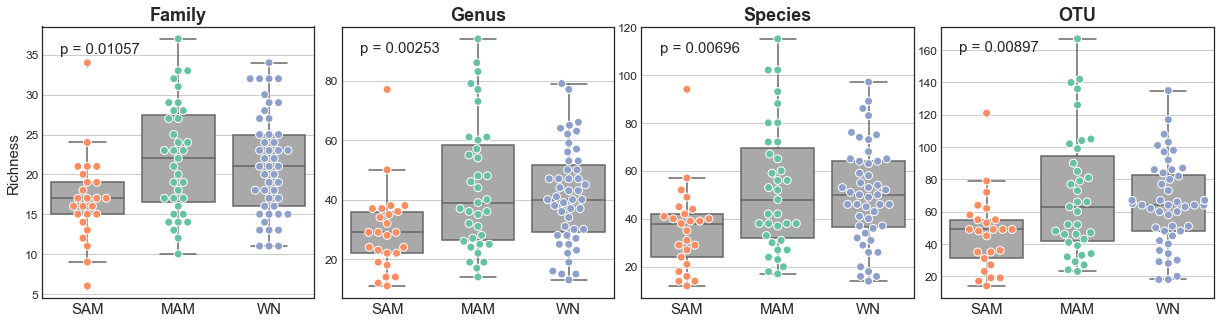

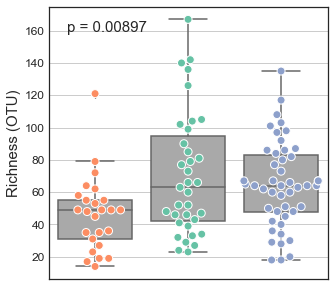

In [7]:
# Alpha diversity
df_richness = sy.microbiome.alpha_diversity(X=ds_otus["QC(samples)"], taxonomy=ds_otus.metadata_attributes, obsv_type="patient", metric="richness")
df_richness.columns = df_richness.columns[:-1].tolist() + ["OTU"]

# Get groupings by taxonomy
data = list()
for id_class, df in df_richness.groupby(ds_otus.y):
    df = df.loc[:,["Family", "Genus", "Species", "OTU"]]
    df.columns = df.columns.map(lambda x: ( x, id_class))
    data.append(df.reset_index(drop=True))

# Plot richness for various taxonomy levels
# classes = ["WN", "MAM", "SAM"]
classes = ["SAM", "MAM", "WN"]

df_richness_grouped = pd.concat(data, axis=1).sort_index(axis=1)
df_richness_grouped = df_richness_grouped[[*itertools.product(["Family", "Genus", "Species", "OTU"], classes)]]
with plt.style.context("seaborn-white"):
    fig, axes = plt.subplots(figsize=(21,5), ncols=4, sharey=False, gridspec_kw=dict(wspace=0.1,  hspace=0))
    for id_taxon, df in df_richness_grouped.groupby(lambda x:x[0], axis=1):
        df.columns = df.columns.droplevel(0)
        i = dict(zip(["OTU", "Species", "Genus", "Family"][::-1], range(4)))[id_taxon]
        ax = plot_distribution(df, ylabel={True:"Richness", False:None}[i == 0], title=id_taxon, ax=axes[i], color_swarm=df.columns.map(lambda x:colors_status.class_colors[x]), swarm_kws={"edgecolor":"white"}, x_rot=0, figsize=(21,5)) 
        axes[i].set_yticklabels(list(map(lambda y:str(float(eval(y.get_text()))).split(".")[0], axes[i].get_yticklabels()))) #! I hate this
        axes[i].yaxis.grid(True)
        stat, p = stats.kruskal(df["WN"].dropna(), df["MAM"].dropna(), df["SAM"].dropna())
        axes[i].text(-0.3, max(axes[i].get_ylim())*0.95, "p = %0.5f"%p, ha="left", va="top", fontsize=15)
        
# Only plot OTU level
    fig, ax = plt.subplots(figsize=(5,5), ncols=1, sharey=False, gridspec_kw=dict(wspace=0.1,  hspace=0))
    df = df_richness_grouped["OTU"]
    ax = plot_distribution(df, ylabel="Richness (OTU)", ax=ax, color_swarm=df.columns.map(lambda x:colors_status.class_colors[x]), swarm_kws={"edgecolor":"white"}, x_rot=0, figsize=(21,5)) 
    ax.set_xticklabels([])
    ax.set_yticklabels(list(map(lambda y:str(float(eval(y.get_text()))).split(".")[0], ax.get_yticklabels()))) 
    ax.yaxis.grid(True)
    stat, p = stats.kruskal(df["WN"].dropna(), df["MAM"].dropna(), df["SAM"].dropna())
    ax.text(-0.3, max(ax.get_ylim())*0.95, "p = %0.5f"%p, ha="left", va="top", fontsize=15)
    
df_richness_grouped["OTU"].var(axis=0)

# SAM     547.423333
# MAM    1458.357983
# WN      706.539315
# dtype: float64

df_richness

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


167

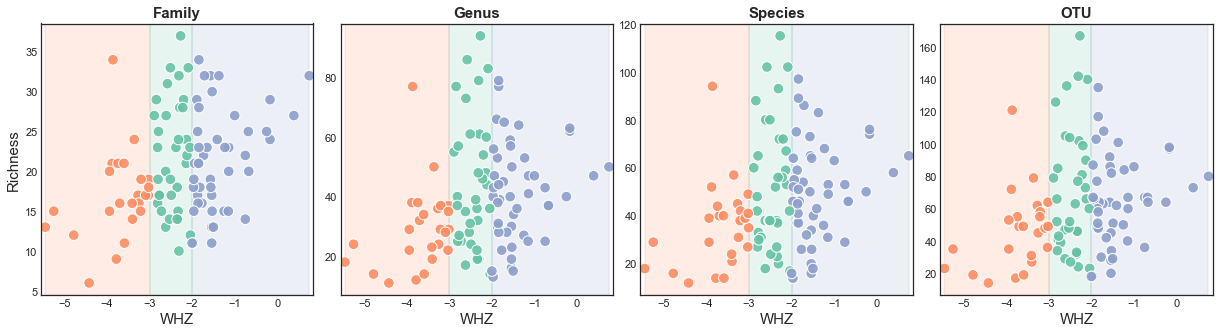

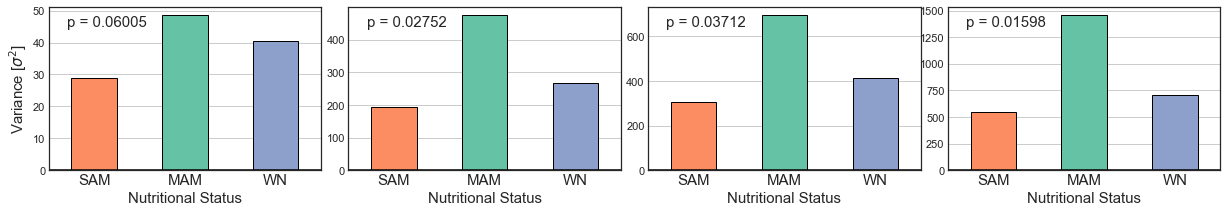

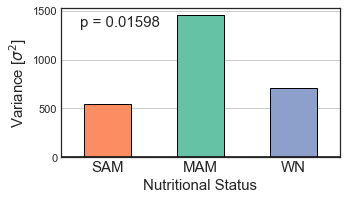

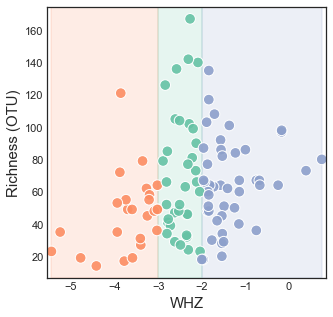

In [8]:
# Plotting WHZ and Richness
# classes = ["WN", "MAM", "SAM"]
classes = ["SAM", "MAM", "WN"]
with plt.style.context("seaborn-white"):
    # WHZ vs. Richness
    fig, axes = plt.subplots(figsize=(21,5), ncols=4, sharex=True, sharey=False, gridspec_kw=dict(wspace=0.1, hspace=0))
    for i, id_taxon in enumerate(["Family", "Genus", "Species", "OTU"]):
        df = pd.concat([df_meta_samples.loc[df_richness.index,"WHZ"].to_frame(), df_richness[id_taxon].to_frame()], axis=1)
        sy.visuals.plot_scatter(data=df,c=colors_status.obsv_colors, ax=axes[i], title=id_taxon, xlabel="WHZ", ylabel={True:"Richness", False:None}[i==0])
        axes[i].legend(fontsize=15)
        xlim = axes[i].get_xlim()
        ylim = axes[i].get_ylim()
        axes[i].fill_between([df["WHZ"].min(), -3], *ylim, color=colors_status.class_colors["SAM"], linestyle="-", linewidth=1.618, alpha=0.1618, zorder=0)
        axes[i].fill_between([-3, -2], *ylim, color=colors_status.class_colors["MAM"], linestyle="-", linewidth=1.618, alpha=0.1618, zorder=0)
        axes[i].fill_between([-2, df["WHZ"].max()], *ylim, color=colors_status.class_colors["WN"], linestyle="-", linewidth=1.618, alpha=0.1618, zorder=0)
        axes[i].set_xlim(xlim)
        axes[i].set_ylim(ylim)
        pad = 0.1
        axes[i].set_xlim((df["WHZ"].min()-pad, df["WHZ"].max()+pad))
        
    # Variance
    fig, axes = plt.subplots(figsize=(21,3), ncols=4, sharex=True, sharey=False, gridspec_kw=dict(wspace=0.1, hspace=0))
    for i, id_taxon in enumerate(["Family", "Genus", "Species", "OTU"]):
        df = pd.concat([df_meta_samples.loc[df_richness.index,"WHZ"].to_frame(), df_richness[id_taxon].to_frame()], axis=1)
        axes[i].axhline(0, color="black")
        if i == 0:
            axes[i].set_ylabel("Variance [$σ^2$]", fontsize=15)
        df[id_taxon].groupby(ds_otus.y).var()[classes].plot(kind="bar", ax=axes[i],color=colors_status.class_colors[classes], edgecolor="black")
        axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=15, rotation=0)
        axes[i].set_xlabel("Nutritional Status", fontsize=15)
        axes[i].yaxis.grid(True)

        
        stat, p = stats.levene(*map(lambda x:x[1].dropna().values, df[id_taxon].groupby(ds_otus.y)))
        axes[i].text(-0.3, max(axes[i].get_ylim())*0.95, "p = %0.5f"%p, ha="left", va="top", fontsize=15)
        
    
    # Only OTU
    fig, ax = plt.subplots(figsize=(5,2.75))
    axes = [ax]
    for i, id_taxon in enumerate([ "OTU"]):
        df = pd.concat([df_meta_samples.loc[df_richness.index,"WHZ"].to_frame(), df_richness[id_taxon].to_frame()], axis=1)
        axes[i].axhline(0, color="black")
        axes[i].set_ylabel("Variance [$σ^2$]", fontsize=15)
        df[id_taxon].groupby(ds_otus.y).var()[classes].plot(kind="bar", ax=axes[i],color=colors_status.class_colors[classes], edgecolor="black")
        axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=15, rotation=0)
        axes[i].set_xlabel("Nutritional Status", fontsize=15)
        axes[i].yaxis.grid(True)

        
        stat, p = stats.levene(*map(lambda x:x[1].dropna().values, df[id_taxon].groupby(ds_otus.y)))
        axes[i].text(-0.3, max(axes[i].get_ylim())*0.95, "p = %0.5f"%p, ha="left", va="top", fontsize=15)
        
    fig, ax = plt.subplots(figsize=(5,5),  sharex=True, sharey=False, gridspec_kw=dict(wspace=0.1, hspace=0))
    axes = [ax]
    for i, id_taxon in enumerate(["OTU"]):
        df = pd.concat([df_meta_samples.loc[df_richness.index,"WHZ"].to_frame(), df_richness[id_taxon].to_frame()], axis=1)
        sy.visuals.plot_scatter(data=df,c=colors_status.obsv_colors, ax=axes[i],  xlabel="WHZ", ylabel={True:"Richness ({})".format(id_taxon), False:None}[i==0])
        axes[i].legend(fontsize=15)
        xlim = axes[i].get_xlim()
        ylim = axes[i].get_ylim()
        axes[i].fill_between([df["WHZ"].min(), -3], *ylim, color=colors_status.class_colors["SAM"], linestyle="-", linewidth=1.618, alpha=0.1618, zorder=0)
        axes[i].fill_between([-3, -2], *ylim, color=colors_status.class_colors["MAM"], linestyle="-", linewidth=1.618, alpha=0.1618, zorder=0)
        axes[i].fill_between([-2, df["WHZ"].max()], *ylim, color=colors_status.class_colors["WN"], linestyle="-", linewidth=1.618, alpha=0.1618, zorder=0)
        axes[i].set_xlim(xlim)
        axes[i].set_ylim(ylim)
        pad = 0.1
        axes[i].set_xlim((df["WHZ"].min()-pad, df["WHZ"].max()+pad))
        
df[id_taxon].max()

## Relative abundance of Family-level taxonomy

In [9]:
def differential_abundance(X:pd.DataFrame, y:pd.Series, reference_class=None, method="ALDEx2", return_type="dataframe", aldex2_kws=dict(), random_state=0):
    # Assertions
    assert_acceptable_arguments(return_type, {"dict", "dataframe"})
    assert method == "ALDEx2", "Currently, only `algorithm='ALDEx2' is available"
    assert np.all(X.shape[0] == y.size), "X.shape[0] != y.size"
    assert np.all(X.index == y.index), "X.index != y.index"
    
    # Wrappers        
    def run_aldex2(X, y, kws):
        r_X = pandas_to_rpy2(X.T)
        r_y = pandas_to_rpy2(y)
        results = aldex2.aldex(
            reads=r_X, 
            conditions=r_y,
            **_aldex2_kws,
        )
        return rpy2_to_pandas(results)
    
    # ALDEx2
    if method == "ALDEx2":
        ro.r('set.seed')(random_state)
        # Package
        aldex2 = R_package_retrieve("ALDEx2")
        _aldex2_kws=dict(test="t", effect=True, mc_samples=128, denom="all")
        _aldex2_kws.update(aldex2_kws)

        # Multiclass
        classes = set(y.unique())
        if len(classes) > 2:
            assert reference_class is not None, "Please provided a `reference_class` control condition"
            assert reference_class in classes, "`reference_class={}` is not in `y`".format(reference_class)
            
            multiclass_results = dict()
            for query_class in sorted(classes - {reference_class}):
                
                # Subset the samples to include `query_class` and `reference_class`
                y_subset = y[y.map(lambda id_sample: id_sample in {query_class, reference_class})]
                X_subset = X.loc[y_subset.index]
                
                # Run ALDEx2
                multiclass_results[query_class] = run_aldex2(X=X_subset, y=y_subset, kws=_aldex2_kws)
            
            # Return a dictionary object {query_class:results}
            if return_type == "dict":
                return multiclass_results
            
            # Return a multiindex pd.DataFrame
            if return_type == "dataframe":
                dataframes = list()
                for id_class, df in multiclass_results.items():
                    df.columns = df.columns.map(lambda metric: (id_class, reference_class, metric))
                    df.columns.names = ["Treatment", "Reference", "Metric"]
                    dataframes.append(df)
                return pd.concat(dataframes, axis=1)
            
        # 2 Classes
        else:
            return run_aldex2(X=X, y=y, kws=_aldex2_kws)
        
aldex2_results = dict()
denom = "all"
for taxon_level, df in sy.pv(taxonomy_counts.items(), "ALDEx2", unit=" Taxonomy level"):
    if taxon_level not in {'Life', 'Domain', 'Phylum', 'Class', 'Order', 'Species', 'Genus'}:
        X = sy.utils.filter_compositional(df, tol_prevalence=13) 
        with sy.utils.Suppress(show_stdout=True):
            aldex2_results[taxon_level] = differential_abundance(X=X, y=y_phenotype[X.index], reference_class="WN", aldex2_kws={"test":"t", "denom":denom})


ALDEx2: 100%|██████████| 9/9 [00:32<00:00,  3.58s/ Taxonomy level]


Enterobacteriaceae 0.017930383948414123


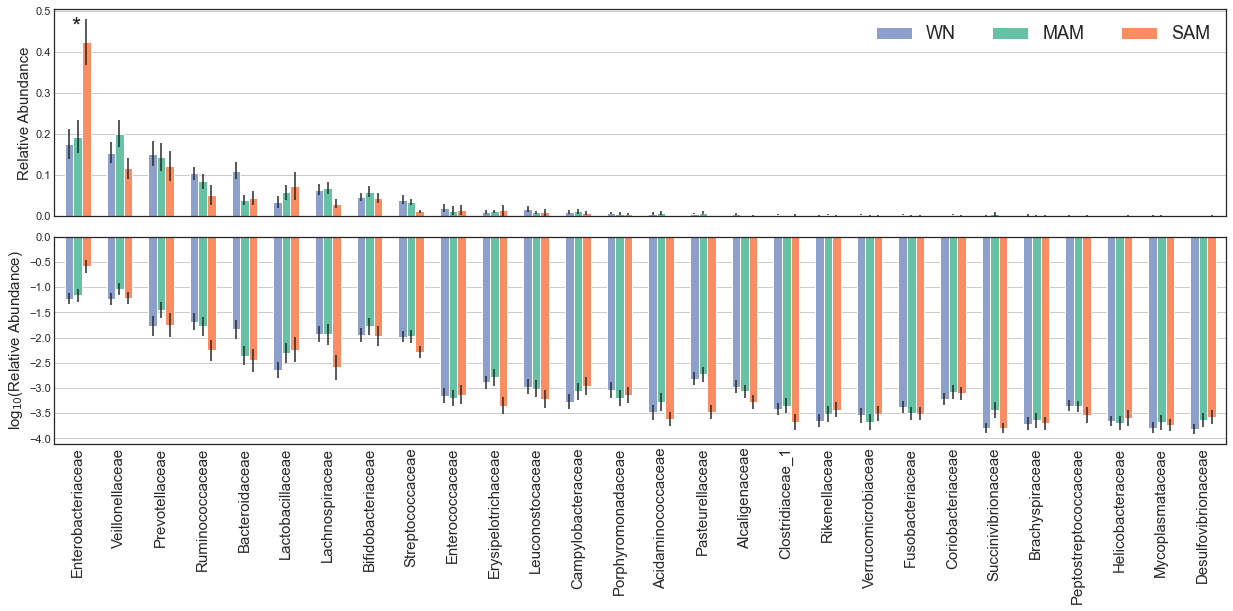

In [10]:

with plt.style.context("seaborn-white"):
    fig, axes = plt.subplots(figsize=(21,8), nrows=2, sharex=True, gridspec_kw={"hspace":0.1})
    
    # Linear-scale
    ax = axes[0]
    df = sy.transmute.normalize_tss(taxonomy_counts["Family"]+1)
    
    # ALDEx2 Results
    family_fdr = aldex2_results["Family"][("SAM", "WN", "wi.eBH")] # There are no statistically significant MAM vs. WN
    
    tol = 0.001
    df_linear = df[df.mean(axis=0)[lambda x: x > tol].index]
    µ_linear = df_linear.groupby(ds_otus.y).mean().loc[["WN", "MAM", "SAM"]]
    µ_linear = µ_linear[µ_linear.sum(axis=0).sort_values(ascending=False).index]
    sem_linear = df_linear.groupby(ds_otus.y).sem()[µ_linear.columns]

#     df_linear = df[df.median(axis=0)[lambda x: x > tol].index]
#     µ_linear = df_linear.groupby(ds_otus.y).median().loc[["WN", "MAM", "SAM"]]
#     µ_linear = µ_linear[µ_linear.sum(axis=0).sort_values(ascending=False).index]
#     sem_linear = df_linear.groupby(ds_otus.y).sem()[µ_linear.columns]
    
    µ_linear.T.plot(kind="bar", yerr=sem_linear.T, ax=ax, color=colors_status.class_colors[µ_linear.index], width=0.618)
    
    # Annotations
    for id_family, fdr in family_fdr[lambda x: x < 0.05].iteritems():
        x = {id_family:µ_linear.columns.get_loc(id_family)}
        labels = {id_family:statistically_significant_symbols(fdr)}
        y = {id_family:µ_linear[id_family].max()}
#         plot_annotation(labels=labels,x=x, y=y, ax=ax, x_pad=-0.15,  fontsize=24)
    ax.set_xlabel("")
    ax.set_ylabel("Relative Abundance", fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
    
    ax.legend_ = None
    
    # Log-scale
    ax = axes[1]
    df_log = np.log10(sy.transmute.normalize_tss(taxonomy_counts["Family"]+1))#.loc[:, µ_linear.index]
    
    µ_log = df_log.groupby(ds_otus.y).mean().loc[["WN", "MAM", "SAM"], µ_linear.columns]
#     µ_log = µ_log[µ_log.sum(axis=0).sort_values(ascending=False).index]
    sem_log = df_log.groupby(ds_otus.y).sem()[µ_log.columns]

#     µ_log = df_log.groupby(ds_otus.y).mean().loc[["WN", "MAM", "SAM"], µ_linear.columns]
# #     µ_log = µ_log[µ_log.sum(axis=0).sort_values(ascending=False).index]
#     sem_log = df_log.groupby(ds_otus.y).sem()[µ_log.columns]
    
    
    
    µ_log.T.plot(kind="bar", yerr=sem_log.T, ax=ax, color=colors_status.class_colors[µ_log.index], width=0.618)
    ax.set_xlabel("")
    ax.set_ylabel("log$_{10}$(Relative Abundance)", fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
    
    # Annotations
    for id_family, fdr in family_fdr[lambda x: x < 0.05].iteritems():
        x = pd.Series({id_family:µ_linear.columns.get_loc(id_family)})
        labels = {id_family:statistically_significant_symbols(fdr)}
        y = pd.Series({id_family:µ_linear[id_family].max()})[x.index]
        sy.visuals.plot_annotation(labels=labels,x=x, y=y, ax=axes[0], x_pad=-0.15,  y_pad=0, fontsize=24, adjust_label_positions=True)
        print(id_family, fdr)
    for ax in axes:
        ax.yaxis.grid(True)
    axes[0].legend(ncol=3, fontsize=18)
    axes[1].legend_.set_visible(False)
   
    
#     # Annotations
#     for id_family, fdr in family_fdr[lambda x: x < 0.05].iteritems():
# #         for µ, ax, y_pad in zip([µ_linear, µ_log], axes, [0.25, -1]):
#         µ = µ_linear
#         y_pad = 0.
#         x = pd.Series({id_family:µ.columns.get_loc(id_family)})
#         labels = {id_family:statistically_significant_symbols(fdr)}
#         y = pd.Series({id_family:µ[id_family].max()})[x.index]
#         sy.visuals.plot_annotation(labels=labels,x=x, y=y, ax=ax, x_pad=-0.15,  y_pad=y_pad, fontsize=24, adjust_label_positions=True)
#         print(id_family, fdr)
# Enterobacteriaceae 0.017930383948414123


## Beta diversity analysis (Isometric log-ratio using phylogentic tree)

Pruned 233 attributes to match components (X.columns)
Inferred association as `dissimilarity`


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.collections.PathCollection at 0x7fb0ccdcbf10>)

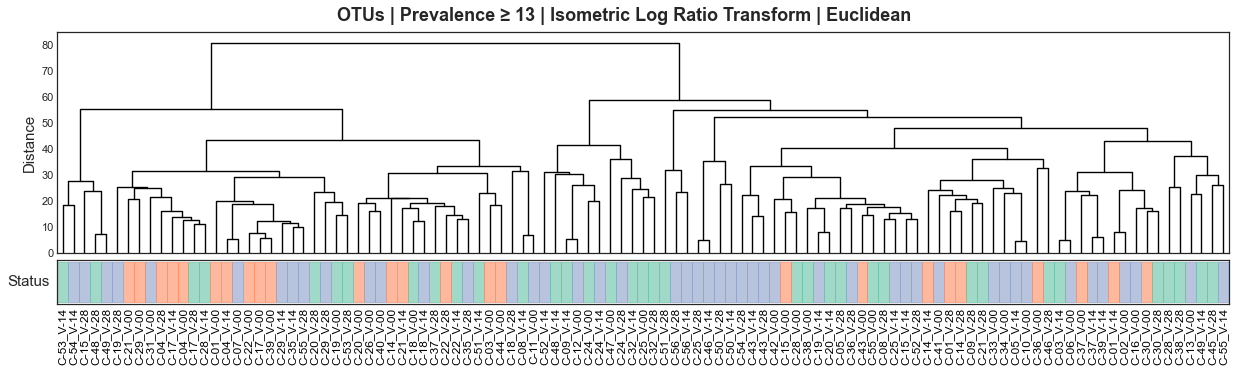

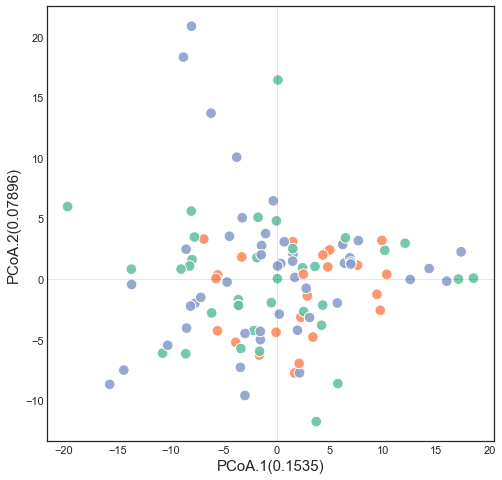

In [11]:
# Isometric log-ratio transform using phylogentic tree
df_ilr = coda.transform_ilr(ds_otus[("QC(samples)", ('prevalence', 13))]+1, tree=tree_16s)

# Pairwise Aitchison distance (Euclidean distance in simplex)
df_dism = sy.symmetry.pairwise(df_ilr, metric="euclidean", axis=0)

# Agglomerative hierarchical clustering
title = "OTUs | Prevalence ≥ 13 | Isometric Log Ratio Transform | Euclidean"
ahc_ilr = sy.Agglomerative(df_dism)
ahc_ilr.add_secondary_class("Status", mapping=ds_otus.y, class_colors=colors_status.class_colors)
ahc_ilr.plot(title=title, show_leaves=True)

# Principal coordinates analysis
sy.ordination.PrincipalCoordinatesAnalysis(df_dism, df_ilr).plot(c=colors_status.obsv_colors)#, show_features=10, arrow_scale=10)

Text(0, 0.5, 'PCoA.2(0.07896)')

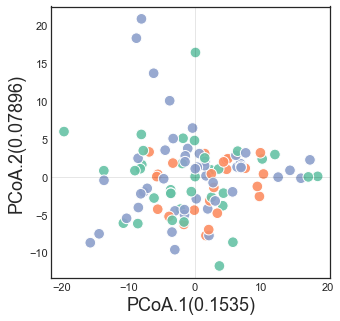

In [12]:
fig, ax, im = sy.ordination.PrincipalCoordinatesAnalysis(df_dism, df_ilr).plot(c=colors_status.obsv_colors, figsize=(5,5))#, show_features=10, arrow_scale=10)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)

SAM	p = 4.6888e-19
WN	p = 8.0032e-05
MAM	p = 0.012502


/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level functio

1.4238907404295364e-05


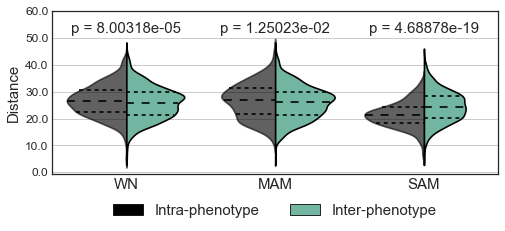

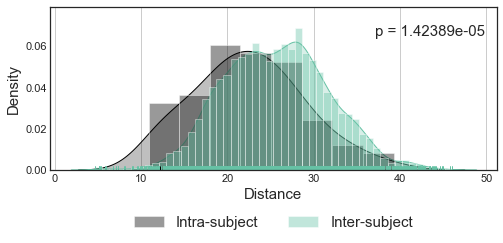

In [13]:
# Intra-inter phenotype beta diversity

# Violinplots
cmap = sns.color_palette(["black", colors_status.class_colors["MAM"]], as_cmap=True)
df_beta = sy.microbiome.beta_diversity(df_dism, ds_otus.y, label_intra="Intra-phenotype", label_inter="Inter-phenotype")[["WN", "MAM", "SAM"]]
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(8,3))
    sns.violinplot(data=pd.melt(df_beta, value_name="Distance"), x="Class", y="Distance", hue="Diversity",  palette=cmap, linewidth=1.618,  split=True, inner="quartile", ax=ax)
    for violin in ax.collections[::2]:
        violin.set_alpha(0.618)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2, fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
    ax.set_yticklabels(ax.get_yticks(), fontsize=12)
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), fontsize=15)
    ax.yaxis.grid(True)
    for id_class in ds_otus.y.unique():
        u = df_beta[(id_class, "Intra-phenotype")].dropna()
        v = df_beta[(id_class, "Inter-phenotype")].dropna()
        stat, p = stats.mannwhitneyu(u,v)
        print(id_class, "p = {}".format(sy.utils.to_precision( p)), sep="\t")
        ax.text(
            x=df_beta.columns.get_level_values(0).unique().get_loc(id_class), 
            y=ax.get_ylim()[1], 
            s = "p = %0.5e"%p,
            ha="center",
            fontsize=15)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 8)
    
# KDE plots
df_beta = sy.microbiome.beta_diversity(df_dism, ds_otus.metadata_observations["SubjectID(Alias)"])
df_melt = pd.melt(df_beta, value_name="Distance").dropna(how="any", axis=0)
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(8,3))
    u = df_melt.query("Diversity == 'Intra'")["Distance"]
    v = df_melt.query("Diversity == 'Inter'")["Distance"]
    sns.distplot(u, color=cmap[0], ax=ax, rug=True, kde_kws=dict(shade=True), label="Intra-subject")
#     sns.distplot(u, color=sns.color_palette(palette, n_colors=2)[0], ax=ax, label="")

    sns.distplot(v, color=cmap[1], ax=ax, rug=True, kde_kws=dict(shade=True), label="Inter-subject")
    ax.xaxis.grid(True)
    stat, p = stats.mannwhitneyu(u,v)
    ax.text(ax.get_xlim()[1]*0.85, ax.get_ylim()[1]*0.85, s="p = %0.5e"%(p), ha="center", va="center", fontsize=15)
    ax.set_xlabel("Distance", fontsize=15)
    ax.set_ylabel("Density", fontsize=15)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2, fontsize=15)
    print(p)

# SAM	p = 4.6888e-19
# WN	p = 8.0032e-05
# MAM	p = 0.012502
# 1.4238907404295364e-05



## PICRUSt2

In [14]:
# Enzyme descriptions
df_description_ec = sy.io.read_dataframe("./Data/enzyme.descriptions.tsv")

# Load PICRUSt2
df_picrust2_ec = sy.io.read_dataframe("./Data/picrust2_output/EC_metagenome_out/pred_metagenome_unstrat.tsv.gz").T
df_picrust2_ec.index = df_picrust2_ec.index.map(lambda id_sample:old_to_new[id_sample])


picrust2_statistics = defaultdict(dict)
for id_enzyme, abundance in sy.pv(df_picrust2_ec.T.iterrows()):
    abundance = abundance[lambda x: x != 0]

    wn = abundance[y_phenotype == "WN"]
    
    for id_class in ["SAM", "MAM"]:
        un = abundance[y_phenotype == id_class]

        if all([un.size > 20, wn.size > 20]):
            picrust2_statistics[id_enzyme][("WN", "median")] = wn.median()
            picrust2_statistics[id_enzyme][("WN", "var")] = wn.var()
            
            picrust2_statistics[id_enzyme][(id_class, "median")] = un.median()
            picrust2_statistics[id_enzyme][(id_class, "var")] = un.var()
            stat, p = stats.mannwhitneyu(wn, un)
#         else:
#             stat = "insufficient_size"
#             p = np.nan
            picrust2_statistics[id_enzyme][(id_class, "mannwhitney|stat")] = stat
            picrust2_statistics[id_enzyme][(id_class, "mannwhitney|p_value")] = p
        
df_picrust2_statistics = pd.DataFrame(picrust2_statistics).T
for id_class in ["SAM", "MAM"]:
    df_picrust2_statistics[(id_class, "mannwhitney|fdr_value")] = sy.statistics.p_adjust(df_picrust2_statistics[(id_class, "mannwhitney|p_value")])
df_picrust2_statistics = df_picrust2_statistics.sort_index(axis=1)
print(df_picrust2_statistics.shape)
df_picrust2_statistics.head()


1636it [00:04, 360.38it/s]


(1390, 12)


MAM                                       \
             mannwhitney|fdr_value mannwhitney|p_value mannwhitney|stat   
EC:1.1.1.1                     0.5            0.357323            783.0   
EC:1.1.1.100                   0.5            0.367871            786.0   
EC:1.1.1.103                   0.5            0.485043            818.0   
EC:1.1.1.11                    0.5            0.356160            617.5   
EC:1.1.1.125                   0.5            0.444820            784.0   

                                                       SAM  \
                median           var mannwhitney|fdr_value   
EC:1.1.1.1    4746.280  3.325232e+08              0.150883   
EC:1.1.1.100  8091.740  8.579752e+08              0.056931   
EC:1.1.1.103   495.230  3.428611e+06              0.203698   
EC:1.1.1.11      5.000  2.921169e+05              0.018586   
EC:1.1.1.125   176.485  5.306113e+06              0.363767   

                                                                          \
             mannwhitney|p_value mannwhitney|stat   median           var   
EC:1.1.1.1              0.111559            484.0  4305.29  4.639302e+07   
EC:1.1.1.100            0.010543            392.0  4487.18  5.361040e+07   
EC:1.1.1.103            0.163119            504.0   773.96  3.243983e+06   
EC:1.1.1.11             0.000762            251.5    68.57  1.120286e+06   
EC:1.1.1.125            0.335124            551.0   164.03  4.216305e+06   

                   WN                
               median           var  
EC:1.1.1.1    5782.52  2.633901e+08  
EC:1.1.1.100  8185.02  7.086097e+08  
EC:1.1.1.103   443.47  1.714255e+06  
EC:1.1.1.11      5.07  1.111632e+04  
EC:1.1.1.125   126.42  4.995912e+06

In [15]:



# Run GSEA [Prerank]
# module_name = pd.DataFrame(sy.db.get_database('kegg-module')).T["NAME"]
pathway_name = sy.io.read_dataframe("./Data/prerank_output/kegg_map/kegg_map.gmt", sep="\t", index_col=0, header=None).iloc[:,0]
prerank_output = dict()
# for db in ["kegg_map", "kegg_ortholog-ec"]:
db = "kegg_map"
feature_weights = 1 - df_picrust2_statistics[("SAM", "mannwhitney|fdr_value")][lambda x: x < 0.05].sort_values()
rnk = feature_weights.to_frame().reset_index()
rnk.columns = [0,1] 
feature_sets = "./Data/prerank_output/{}/{}.gmt".format(db, db)
pre_res = gp.prerank(
    rnk=rnk, 
    gene_sets=feature_sets,
    processes=4,min_size=5,
    permutation_num=1000, # reduce number to speed up test
    outdir="./Data/prerank_output/{}".format(db),
    seed=0, 
    no_plot=True,
)

df_prerank = pre_res.res2d.copy()
df_prerank.insert(loc=0, column="db", value=db)
df_prerank.insert(loc=1, column="description", value=df_prerank.index.map(lambda id: pathway_name[id]))
df_prerank.columns = df_prerank.columns.map(lambda x:x.replace("gene","enzyme"))



## Clinical measurements

In [16]:
# # Load clinical data
df = sy.io.read_dataframe("./Data/clinical_measurements.tsv.gz")
df.index = df.index.map(lambda id_sample:old_to_new[id_sample])
ds_clinicals = sy.Dataset(
    data=df,
    metadata_observations=df_meta_samples,
    metadata_target_field="Nutritional_Status",
    name="Clinicals",
    obsv_type="sample",
    attr_type="clinical_measurement",
    metric_type="measurements",
)

# Aggregate pre/post measurements
clinicals_prepost = ["sobr", "leptin", "ghrp", "ghrelin", "molar", "igf1", "igfbp3", "igfbp3", "molarigf1igfbp3"]
clinicals_singular = ['insulin', 'cpeptide', 'salivarycrp', 'cortisol']
idx_clinicals = clinicals_prepost + clinicals_singular
data_clinicals = dict()
for suffix in clinicals_prepost:
    data = ds_clinicals[None].loc[:,["pre{}".format(suffix), "post{}".format(suffix)]]
    data_clinicals[suffix] = data.mean(axis=1)
    
# Add version
ds_clinicals.add_version("aggregated", pd.concat([pd.DataFrame(data_clinicals), ds_clinicals[None][clinicals_singular]], axis=1))
ds_clinicals.add_version(("aggregated","zscore"), sy.transmute.normalize(ds_clinicals["aggregated"], "zscore", axis=0))



Dataset| Clinicals | (107, 20)
        obsv_type: sample
        attr_type: clinical_measurement
        metric_type: measurements
        description: None
datasets: [None, 'aggregated', ('aggregated', 'zscore')]
attribute_subsets: [None]
observation_subsets: [None]
        metadata_observations: 13
        metadata_attributes: 0
        default: None | (107, 20)
        2021-10-25 20:27:06

## Pathogen markers

Dataset| Pathogens | (107, 35)
        obsv_type: sample
        attr_type: pathogen
        metric_type: presence
        description: None
datasets: [None, 'aggregated', ('aggregated', 'tol > 0.04')]
attribute_subsets: [None]
observation_subsets: [None]
        metadata_observations: 13
        metadata_attributes: 0
        default: None | (107, 35)
        2021-10-25 20:27:06

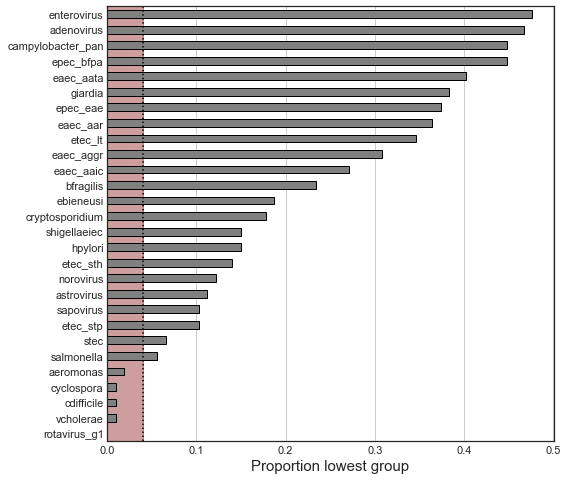

In [17]:
# Load pathogen data
df = sy.io.read_dataframe("./Data/pathogen_markers.tsv.gz")
df.index = df.index.map(lambda id_sample:old_to_new[id_sample])
ds_pathogens = sy.Dataset(
    data=df,
    metadata_observations=df_meta_samples,
    metadata_target_field="Nutritional_Status",
    name="Pathogens",
    obsv_type="sample",
    attr_type="pathogen",
    metric_type="presence",
)

# Aggregating nested pathogens
aggregate = sy.utils.dict_build([
    ("adenovirus", ["adenovirus_f", "adenovirus_pan"]), # v6 only remove adenovirus_pan
    ("cryptosporidium", ["cryptosporidium", "cryptosporidium_hominis", "cryptosporidium_parvum"]), 
#     ("eaec", ["eaec_aaic", "eaec_aar", "eaec_aata", "eaec_aggr"]),
#     ("epec", ["epec_bfpa", "epec_eae", "etec_lt", "etec_sth", "etec_stp"]),
    ("giardia", ["giardia", "giardia_a", "giardia_b"]), # v6 only remove giardia
    ("norovirus", ["norovirusgi", "norovirusgii"]), 
    ("stec", ["stec_stx1", "stec_stx2"]),
])

ds_pathogens.add_version("aggregated", ds_pathogens[None].groupby(lambda x: aggregate[x] if x in aggregate else x, axis=1).sum().astype(bool).astype(int))

# Filtering pathogen markers
tol_homogeneity = 0.04
pathogen_min_proportion = sy.transmute.normalize(ds_pathogens["aggregated"].apply(lambda x:x.value_counts(), axis=0).fillna(0).astype(int).T).min(axis=1).sort_values()
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(8,8))
    pathogen_min_proportion.plot(kind="barh", ax=ax, color="gray", edgecolor="black")
    ax.xaxis.grid(True)
    ax.set_xlabel("Proportion lowest group", fontsize=15)
    ax.axvline(tol_homogeneity, color="black", linestyle=":")
    ax.fill_between([0,tol_homogeneity], *ax.get_ylim(), color="maroon", alpha=0.382)
idx_pathogens_pass_qc = pathogen_min_proportion[lambda x: x > tol_homogeneity].index

# Add version
ds_pathogens.add_version(("aggregated","tol > {}".format(tol_homogeneity)), ds_pathogens["aggregated"].loc[:,idx_pathogens_pass_qc].groupby(lambda x: aggregate[x] if x in aggregate else x, axis=1).sum().astype(bool).astype(int))


## Multimodal dataset

In [18]:
# Merge datasets
df = pd.concat([
    ds_otus[('QC(samples)', ("prevalence",13),  "clr", "zscore")],
    ds_clinicals[('aggregated', 'zscore')],
    ds_pathogens[("aggregated", "tol > {}".format(tol_homogeneity))],
    
], axis=1)

# Nodes
ds_multimodal = sy.Dataset(
    data=df, 
    name="Nodes", 
    obsv_type="sample",
    attr_type="multimodal",
    metadata_observations=df_meta_samples,
    metadata_target_field="Nutritional_Status",
)

# Mapping
y_modality = sy.utils.dict_build([
    ("microbiome", ds_otus[('QC(samples)', ("prevalence",13),  "clr", "zscore")]), 
    ("clinical", ds_clinicals[('aggregated', 'zscore')]), 
    ("pathogen", ds_pathogens[("aggregated", "tol > {}".format(tol_homogeneity))])], 
    into=pd.Series,
)

# Colors
colors_modality = sy.Chromatic.from_classes(y_modality, palette=sns.color_palette(palette=['#bebada', '#8dd3c7', '#fb8072']))

ds_multimodal
# Dataset| Nodes | (107, 190)
# ===========================
#         obsv_type: sample
#         attr_type: multimodal
#         metric_type: None
#         description: None
# datasets: [None]
# attribute_subsets: [None]
# observation_subsets: [None]
#         metadata_observations: 13
#         metadata_attributes: 0
#         default: None | (107, 190)
#         2021-01-27 22:01:28

Dataset| Nodes | (107, 190)
        obsv_type: sample
        attr_type: multimodal
        metric_type: None
        description: None
datasets: [None]
attribute_subsets: [None]
observation_subsets: [None]
        metadata_observations: 13
        metadata_attributes: 0
        default: None | (107, 190)
        2021-10-25 20:27:06

## Linear mixed-effects models

Dataset| Nodes | (107, 190)
        obsv_type: sample
        attr_type: multimodal
        metric_type: None
        description: None
datasets: [None, 'residuals']
attribute_subsets: [None]
observation_subsets: [None]
        metadata_observations: 13
        metadata_attributes: 0
        default: None | (107, 190)
        2021-10-25 20:27:06

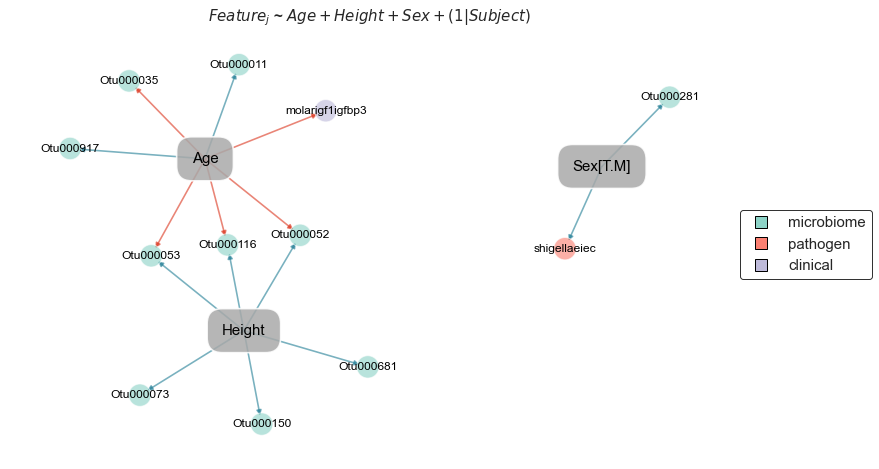

In [19]:
# MixedLM
df_design = df_meta_samples.loc[ds_multimodal[None].index, ["Sex", "SubjectID(Alias)", "Height", "Age[Days]"]]
df_design.columns = ["Sex", "SubjectID", "Height", "Age"]
for id_field in ["Height", "Age"]:
    df_design[id_field] = sy.transmute.normalize_zscore(df_design[id_field])
    
# # Multiple regression
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     mixedlm = sy.regression.MixedEffectsLinearModel(name="Multimodal", attr_type="multimodal", obsv_type="sample")
#     mixedlm.fit(X=ds_multimodal[None], Y=df_design, random_effect_variable="SubjectID", fixed_effects_variables=["Sex", "Age", "Height"], assert_missing_values=False)
# mixedlm.create_graph()
# mixedlm.to_file("./Data/mixedlm.multimodal__fixed_age-sex-height__random_subject.anonymous.pkl")

# # Load MixedLMs
mixedlm = sy.io.read_object("./Data/mixedlm.multimodal__fixed_age-sex-height__random_subject.pkl")
mixedlm.plot_graph(title = "$Feature_j$ ~ $Age + Height + Sex + (1|Subject)$", node_colors=colors_modality.obsv_colors, show_node_labels=True, legend=colors_modality.class_colors[colors_modality.y[set(mixedlm.graph.nodes()) & set(colors_modality.y.index)].unique()])

# Update dataset
df = mixedlm.residuals_
df.index = df.index.map(lambda id_sample: old_to_new[id_sample])
ds_multimodal.add_version("residuals", df.loc[ds_multimodal.index])

In [20]:
# Sex-associated features

# shigellaeiec
gb = ds_multimodal[None]["shigellaeiec"].astype("category").groupby(df_design["Sex"])
table = gb.value_counts().values.reshape((2,2))
chi2, p, dof, ex = stats.chi2_contingency(table)

# Otu000281
gb = ds_multimodal[None]["Otu000281"].dropna().groupby(df_design["Sex"])
stat, p = stats.mannwhitneyu(*map(lambda item: item[1], gb))
ds_otus.m1.loc["Otu000281"]["Taxonomy"]

'Root;Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Escherichia-Shigella'

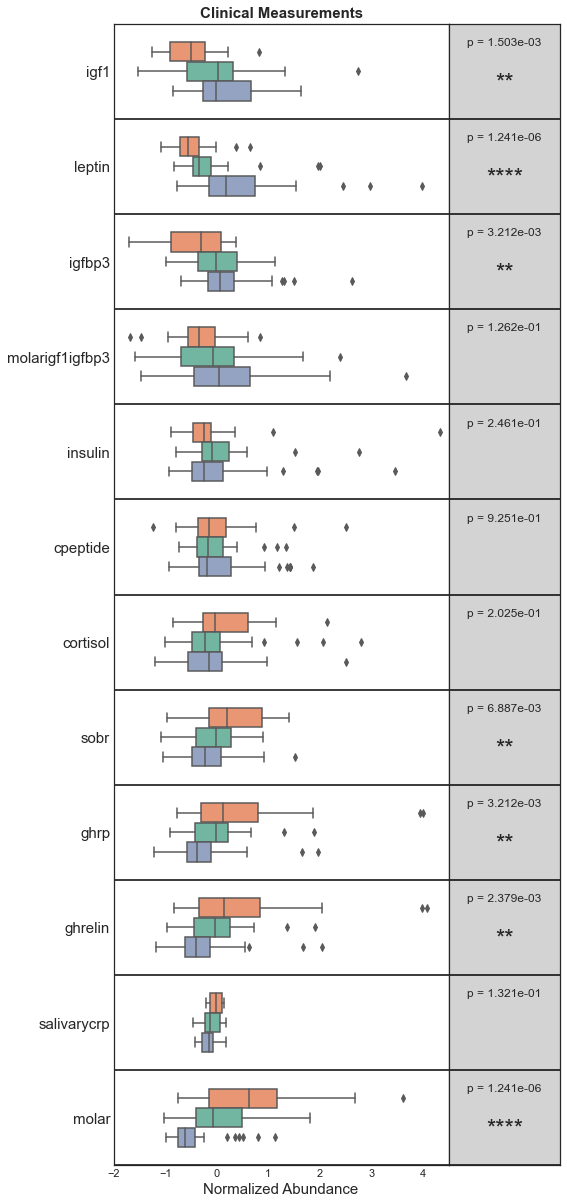

In [21]:
# Clinical Measurements
features = ds_clinicals["aggregated"].columns
df = ds_multimodal["residuals"].stack().to_frame().reset_index()#.dropna(how="any", axis=0)
df.columns = ["SampleID", "Feature", "Value"]
df["Nutritional_Status"] = df["SampleID"].map(lambda x: ds_otus.y[x])#, categories=["SAM", "MAM", "WN"], ordered=True))
df_query = df.loc[df["Feature"].map(lambda x: x in features)].reset_index(drop=True)


# Plot
query = ds_clinicals[("aggregated")].columns
with plt.style.context("seaborn-white"):
    a = 0.75
    text_facecolor="lightgray"
    fig, axes = plt.subplots(figsize=(8,21), ncols=2, gridspec_kw=dict(width_ratios=[a, 1-a], wspace=0) )
    ax_distribution = axes[0]
    ax_stats = axes[1]
    
    order = ds_multimodal["residuals"][query].groupby(y_phenotype, axis=0).mean().T.sort_values(["SAM", "MAM", "WN"]).index
    hue_order = ["SAM", "MAM", "WN"]
    
    # Boxplot
    sns.boxplot(
        data=df_query, 
        y="Feature", 
        x="Value", 
        hue="Nutritional_Status", 
        ax=ax_distribution, 
        palette=sns.color_palette(colors_status.class_colors[hue_order]), 
        hue_order=hue_order, 
        order=order,
        orient="h",
        width=0.618,
        
    )

    ylim = ax_distribution.get_ylim()
    ax_distribution.set_xlim(-2, 4.5)
    ax_distribution.legend_.set_visible(False)
#     ax_stats.legend_.set_visible(False)
    ax_distribution.set_xlabel("Normalized Abundance", fontsize=15)
    ax_distribution.set_yticklabels(ax_distribution.get_yticklabels(), fontsize=15)
    ax_distribution.set_ylabel(None)
    ax_distribution.set_title("Clinical Measurements", fontsize=15, fontweight="bold")

   
    # Peripheral axes
    ax_stats.set_yticklabels([])
    ax_stats.set_xticklabels([])
    ax_stats.set_facecolor(text_facecolor)

    # Get positions and set grid
    for pos, label in zip(ax_distribution.get_yticks(), ax_distribution.get_yticklabels()):
        pos_line = pos + 0.5
        ax_distribution.axhline(pos_line, color="black")
        ax_stats.axhline(pos_line, color="black")

    # Statistical Significance
    p_values = dict()
    positions = dict()
    for pos, label in zip(ax_distribution.get_yticks(), ax_distribution.get_yticklabels()):
        feature = label.get_text()
        stat, p = stats.kruskal(*map(lambda item: item[-1].values, df_query.query("Feature == '{}'".format(feature)).groupby("Nutritional_Status")["Value"]))
        positions[feature] = pos
        p_values[feature] = p
    fdr_values = sy.statistics.p_adjust(p_values)
    
    # Axis stats
    for feature, fdr in fdr_values.items():
        pos = positions[feature]
        ax_stats.text(y=pos - 0.25, x=0.5, s="p = {:.3e}".format(fdr), ha="center", fontsize=12, va="bottom")
        if fdr < 0.05:
            ax_stats.text(y=pos+0.25, x=0.5, s=sy.statistics.statistically_significant_symbols(fdr), ha="center", fontsize=24, va="bottom")
    ax_stats.set_yticks(ax_distribution.get_yticks())
    ax_stats.set_ylim(ax_distribution.get_ylim())
#     ax_distribution.set_ylim(max(ax_distribution.get_ylim()), min(ax_distribution.get_ylim())+0.1)
#     ax_distribution.legend(*sy.utils.format_mpl_legend_handles(colors_status.class_colors[hue_order]), ncol=3, loc="lower center", bbox_to_anchor=[0.5,-0.0618, 0, 0], fontsize=15, markerscale=2)


<ipython-input-22-d0bbdb925446>:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for id_class, df in ds_pathogens["aggregated"][ds_pathogens["aggregated"].columns & ds_multimodal["residuals"].columns].groupby(y_phenotype):


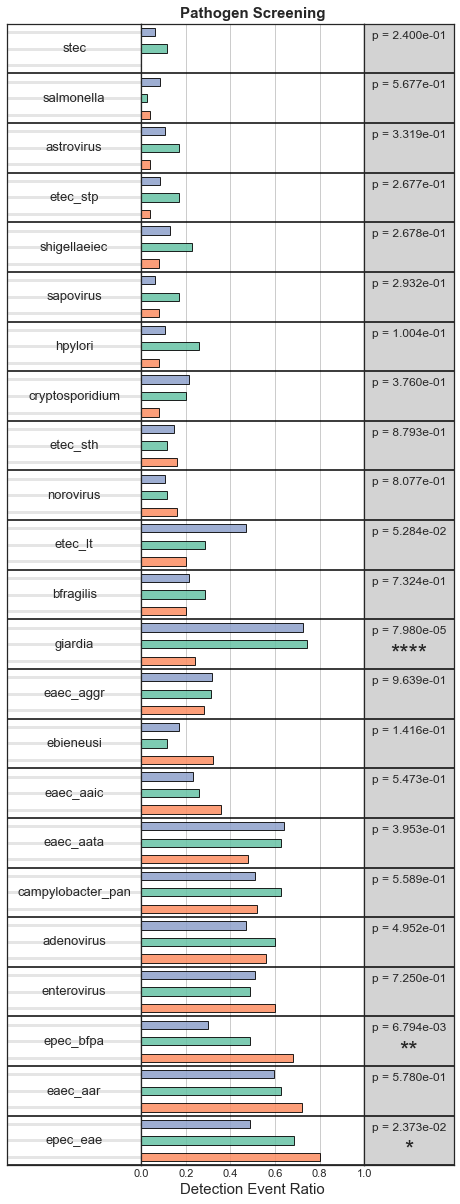

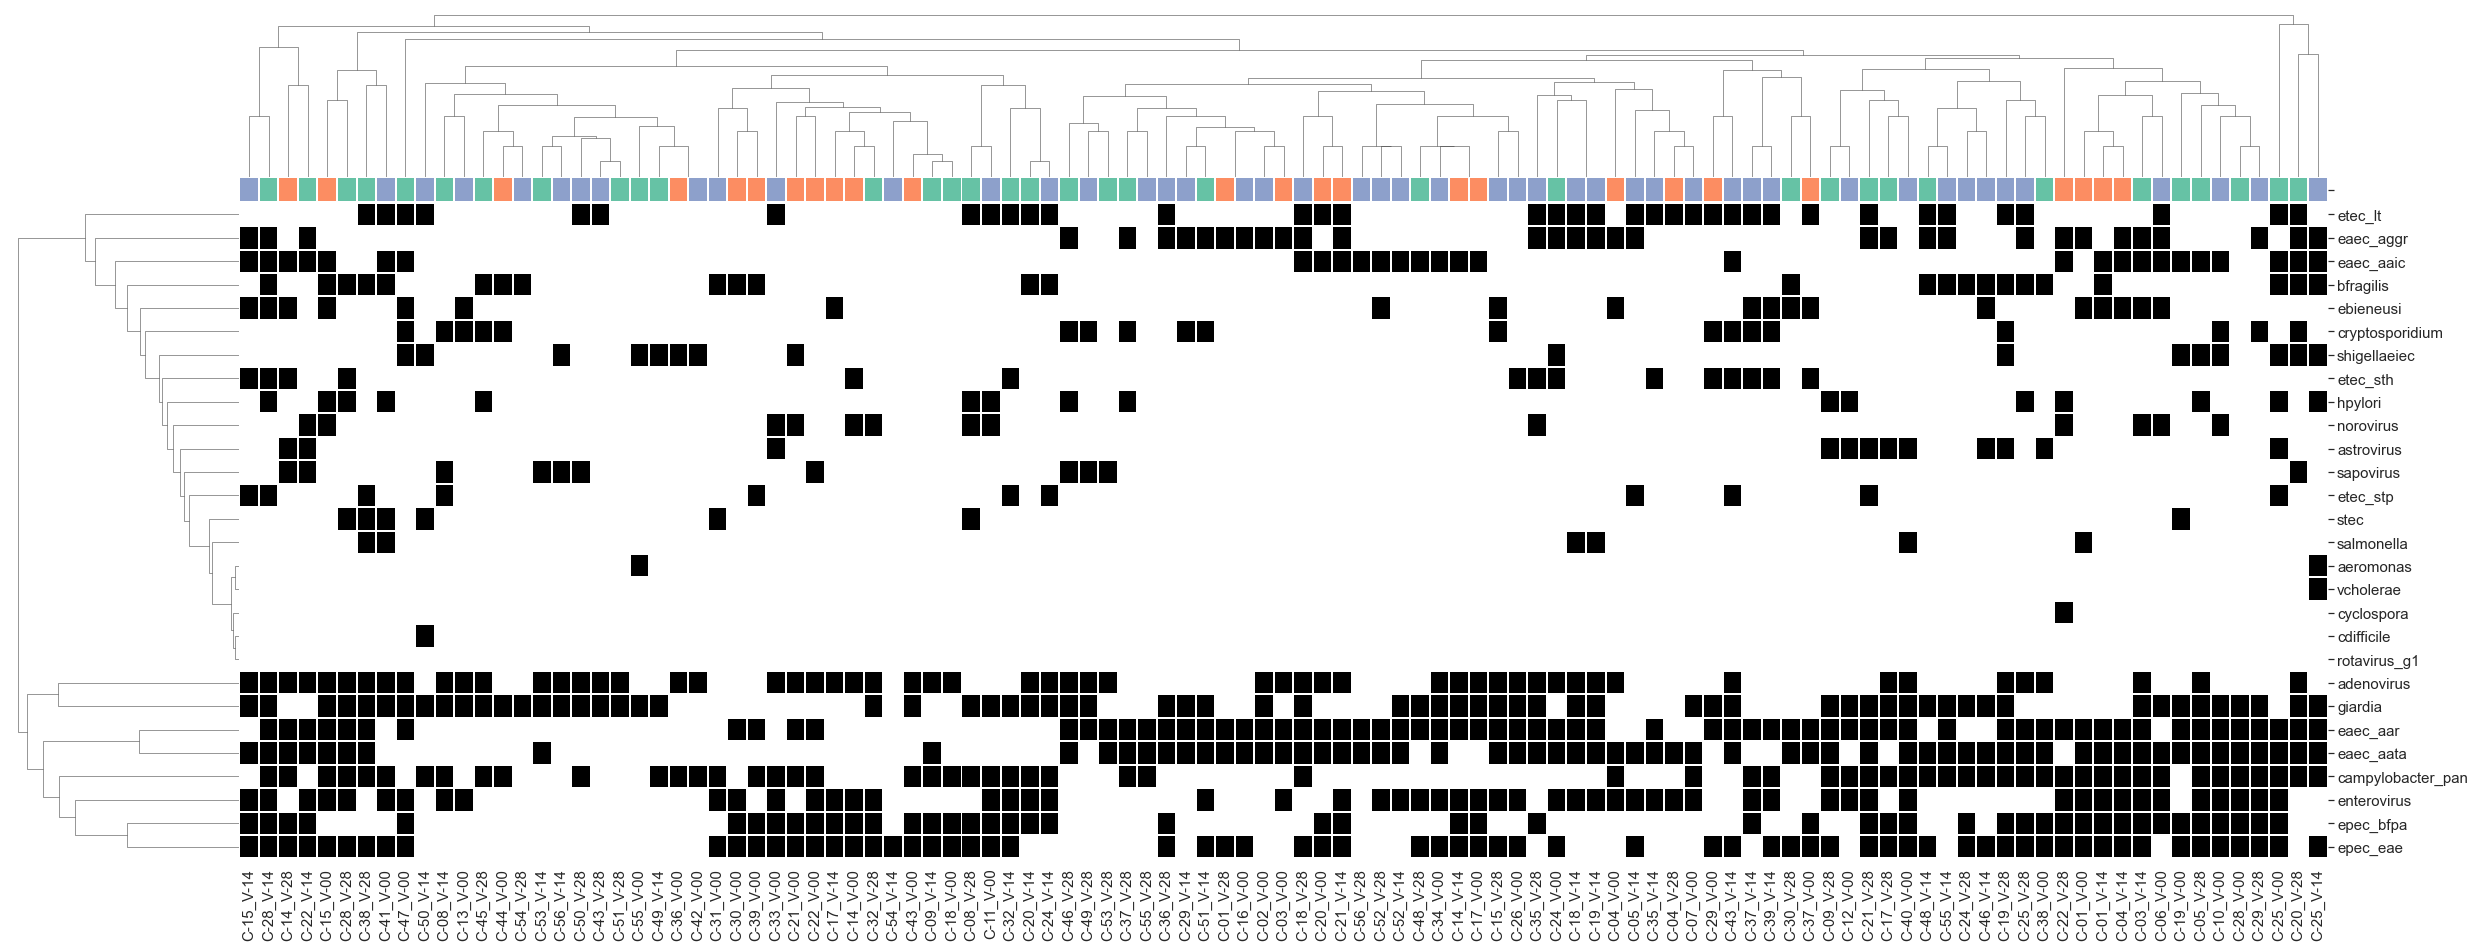

In [22]:
# # Plot presence vs. absence
dataframe = defaultdict(dict)
for id_class, df in ds_pathogens["aggregated"][ds_pathogens["aggregated"].columns & ds_multimodal["residuals"].columns].groupby(y_phenotype):
    for feature, data in df.T.iterrows():
        data = data.map(lambda x: {0:"Not Detected", 1:"Detected"}[x])
        for u, v in data.value_counts().items():
            dataframe[(feature, id_class)][u] = v
df = pd.DataFrame(dataframe).fillna(0).astype(int).sort_index(axis=1)
features = df.loc["Detected"].xs("SAM", level=1).sort_values(ascending=False).index
order = list(itertools.product(features, ["SAM", "MAM", "WN"]))
df = df[order]

# Plot
R_stats = sy.r_wrappers.R_package_retrieve("stats")
from rpy2.robjects import numpy2ri

with plt.style.context("seaborn-white"):
    a = 0.3
    b = 0.5
    text_facecolor="lightgray"
    fig, axes = plt.subplots(figsize=(8,21), ncols=3, gridspec_kw=dict(width_ratios=[a, b, 1 - (a + b)], wspace=0) )
    ax_barchart = axes[1]
#     df.T.plot(kind="barh", stacked=True, ax=ax_barchart, cmap=plt.cm.Reds_r, linewidth=1.618, edgecolor="black", alpha=0.5)
#     ax_barchart.set_xlabel("Detection Events [$Samples$]", fontsize=15)
    sy.transmute.normalize_tss(df.T)["Detected"].plot(kind="barh", stacked=True, ax=ax_barchart, color=df.columns.map(lambda x: colors_status.class_colors[x[-1]]), linewidth=1.,linestyle="-", edgecolor="black", alpha=0.85)
    ax_barchart.set_xlabel("Detection Event Ratio", fontsize=15)


#     ax.legend(**sy.utils.LEGEND_KWS)
#     ax_barchart.legend_.set_visible(False)
    phenotype_grid = list(map(lambda ticklabel:ticklabel.get_text().split(", ")[-1][:-1], ax_barchart.get_yticklabels()))
    ax_barchart.xaxis.grid(True)
    ax_barchart.set_title("Pathogen Screening", fontsize=15, fontweight="bold")
    ax_barchart.set_yticklabels([])
   
    # Peripheral axes
    ax_labels = axes[0]
    ax_labels.set_yticklabels([])
    ax_labels.set_xticklabels([])
    for i in ax_barchart.get_yticks():
        ax_labels.axhline(i, color="black", alpha=0.1, linewidth=3)
    ax_stats = axes[2]
    ax_stats.set_yticklabels([])
    ax_stats.set_xticklabels([])
    ax_stats.set_facecolor(text_facecolor)

    # Get positions and set grid
    positions = dict()
    p_values = dict()
    for i, feature in zip(range(0, len(ax_barchart.get_yticks()), 3), features):
        pos = ax_barchart.get_yticks()[i]
        positions[feature] = pos
        ax_barchart.axhline(pos-0.5, color="black")
        ax_labels.axhline(pos-0.5, color="black")
        ax_stats.axhline(pos-0.5, color="black")
        ax_labels.text(y=pos+1, x=0.5, s=feature, rotation=0, fontsize=13, ha="center", va="center")

    # Statistical Significance
    numpy2ri.activate() # Activate rpy2
    for feature in features:
        obs = df[feature].T#.values
        try:
#             chi2, p, dof, ex = stats.chi2_contingency(obs)
            p = R_stats.fisher_test(obs.values)[0][0]
        except NotImplementedError:
            p = np.nan
        p_values[feature] = p
    numpy2ri.deactivate() # Deactivate rpy2
    fdr_values = pd.Series(p_values).sort_values()
    
    # Axis stats
    for feature, fdr in fdr_values.items():
        pos = positions[feature]
        ax_stats.text(y=pos + 1.618, x=0.5, s="p = {:.3e}".format(fdr), ha="center", fontsize=12)
        if fdr < 0.05:
            ax_stats.text(y=pos , x=0.5, s=sy.statistics.statistically_significant_symbols(fdr), ha="center", fontsize=24)
    for ax in axes:
        ax.set_yticks(ax_barchart.get_yticks())
        ax.set_ylim(ax_barchart.get_ylim())
    ax_barchart.set_xlim((0,1))
    
#     ax_barchart.legend(ncol=2, loc="lower center", bbox_to_anchor=[0.5,-0.0618, 0, 0], fontsize=15)
    
        
# Cluster samples based on pathogen markers
df = ds_pathogens["aggregated"].T
g = sns.clustermap(df, metric="hamming", method="average", cmap="gray_r", figsize=(34,13), edgecolor="white", linewidth=1, col_colors=colors_status.obsv_colors[df.columns], dendrogram_ratio=(0.1, 0.2))#, mask=df_pathogens == 0)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=15)#, fontweight="bold")
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=15)#, fontweight="bold")
# g.ax_heatmap.set_facecolor("gray")
g.cax.set_visible(False)



## Sample-specific perturbation networks

In [23]:
# Data
X_features = ds_multimodal["residuals"]

# Getting reference WN cohort
d_subject_type = dict()
d_type_visits = defaultdict(list)
for id_subject, visits in sy.utils.pd_series_collapse(ds_multimodal.metadata_observations.loc[X_features.index,"SubjectID(Alias)"], type_collection=pd.Index).items():
    y_class = ds_multimodal.y[visits]
    if np.all(y_class == "WN"):
        d_subject_type[id_subject] = "reference"
        d_type_visits["reference"] += visits.tolist()
    else:
        d_subject_type[id_subject] = "query"
        d_type_visits["query"] += visits.tolist()

# Set reference status
reference_label = "WN_"
y = ds_multimodal.y[X_features.index]
y[d_type_visits["reference"]] = reference_label

# Subset samples
reference_visits = y[lambda x: y == reference_label].index
query_visits = y[lambda x: y != reference_label].index
reference_visits.size, query_visits.size

# Update target nutritional status
ds_multimodal.metadata_observations["SSPN_Status"] = y
ds_multimodal.set_metadata_target("SSPN_Status")
# Dataset| Nodes | (107, 190)
# ===========================
#         obsv_type: sample
#         attr_type: multimodal
#         metric_type: None
#         description: None
# datasets: [None, 'residuals']
# attribute_subsets: [None]
# observation_subsets: [None]
#         metadata_observations: 13
#         metadata_attributes: 0
#         default: None | (107, 190)
#         2021-01-27 22:01:28

Dataset| Nodes | (107, 190)
        obsv_type: sample
        attr_type: multimodal
        metric_type: None
        description: None
datasets: [None, 'residuals']
attribute_subsets: [None]
observation_subsets: [None]
        metadata_observations: 13
        metadata_attributes: 0
        default: None | (107, 190)
        2021-10-25 20:27:06

In [24]:
# Sample-specific networks
new_to_old = sy.utils.dict_reverse(old_to_new.to_dict())

_X = ds_multimodal["residuals"].copy()
_X.index = _X.index.map(lambda x: new_to_old[x])
_y = ds_multimodal.y.copy()
_y.index = _y.index.map(lambda x: new_to_old[x])


t=time.time()
sspn = enx.SampleSpecificPerturbationNetwork(name="v5", node_type="multimodal", edge_type="correlation", observation_type="visit", assert_symmetry=False)
sspn.fit(
#     X=ds_multimodal["residuals"], 
#     y=ds_multimodal.y, 
    X=_X,
    y=_y,
    reference="WN_", 
    metric="pearson", 
    stats_summary=[np.nanmean], 
    stats_tests=None, 
    stats_summary_initial=[np.nanmean], 
    copy_ensemble=True,
)

# Compare SSN to reference
µ_reference = sspn.ensemble_reference_.stats_["nanmean"]
µ_query = pd.DataFrame({id_sample:sspn.ensembles_samplespecific_[id_sample].stats_["nanmean"] for id_sample in sspn.ensembles_samplespecific_}).T
X_edges = µ_query - µ_reference

# Remove edges that are empty
idx_edges_empty = (X_edges == 0).sum(axis=0)[lambda x: x == X_edges.shape[0]].index
X_edges = X_edges.drop(idx_edges_empty, axis=1).dropna(how="any", axis=1)

# Create dataset for perturbation profiles
index = sy.io.read_object("./Data/sspn.index.list.pkl") # Match the index of when it was initially run
index = pd.Index(index).map(lambda id_sample: old_to_new[id_sample])
columns = sy.io.read_object("./Data/sspn.columns.list.pkl") # Match the index of when it was initially run
X_edges.index = X_edges.index.map(lambda id_sample: old_to_new[id_sample])

ds_perturbations = sy.Dataset(
    data=X_edges.loc[index, columns],
    metadata_observations=df_meta_samples.loc[index],
    metadata_target_field="Nutritional_Status",
    name="perturbation_matrix",
    obsv_type="sample",
    attr_type="edge",
    metric_type="perturbation",
)

# View the dataset
ds_perturbations

# Duration
print("SSPN Duration: {}".format(sy.utils.format_duration(t)))



Computing summary statistics (WN_):   0%|          | 0/1 [00:00<?, ? stats/s]/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/ensemble_networkx/ensemble_networkx.py:1548: RuntimeWarning: Mean of empty slice
  self.stats_[:,k] = func(values, axis=0)
Computing summary statistics (WN_): 100%|██████████| 1/1 [00:00<00:00,  4.83 stats/s]
Computing sample-specific perturbation networks: 0 samples [00:00, ? samples/s]/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/ensemble_networkx/ensemble_networkx.py:1923: RuntimeWarning: Mean of empty slice
  self.stats_[i,:,k] = func(values_perturbation, axis=0)
Computing sample-specific perturbation networks: 82 samples [04:11,  3.06s/ samples]


SSPN Duration: 00:04:20


## Set up SSPN matrix

Inferred association as `dissimilarity`


(<Figure size 1512x360 with 3 Axes>,
  <matplotlib.axes._axes.Axes at 0x7fad8b428520>])

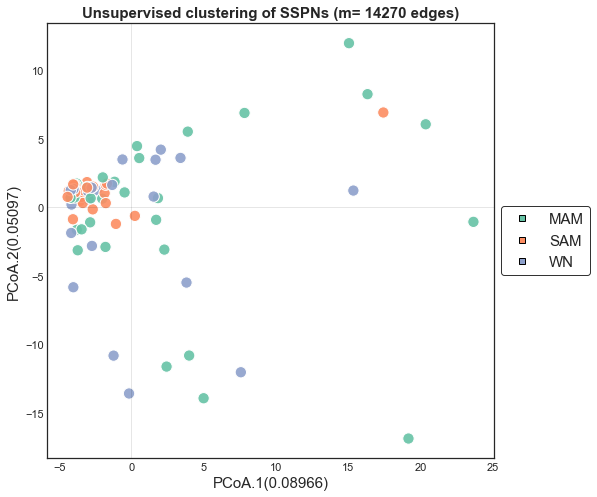

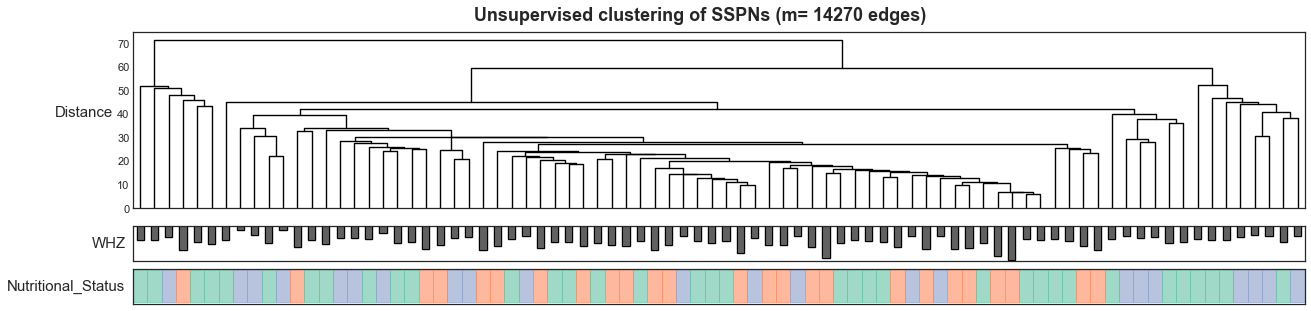

In [25]:
# Let's check the clustering based on the perturbation profiles

# Pairwise Euclidean distance of the perturbations
df_dism = sy.symmetry.pairwise(ds_perturbations.X, metric="euclidean", axis=0)

# PCoA
title="Unsupervised clustering of SSPNs (m= {} edges)".format(ds_perturbations.X.shape[1])
sy.ordination.PrincipalCoordinatesAnalysis(dism=df_dism).plot( c=colors_status.obsv_colors, title=title, legend=colors_status.class_colors)
# sy.ordination.PrincipalCoordinatesAnalysis(dism=df_dism).plot( c=colors_status.obsv_colors)

# Hierarchical clustering
ahc = sy.Agglomerative(df_dism)
ahc.add_secondary_class("Nutritional_Status", y[df_dism.index], class_colors=colors_status.class_colors)
ahc.add_track("WHZ", ds_perturbations.metadata_observations["WHZ"])
ahc.plot(title=title)

# Spoiler alert, doesn't look very good but just wait...

## Leveraging *Clairvoyance* feature selection for phenotype-discriminative community detection

Running computational pipeline:
eigendecomposition	00:00:00
dissimilarity	00:00:00
cluster	00:00:00
dendrogram	00:00:00
convert_to_tree	00:00:00
convert_to_graph	00:00:00


Inferred association as `dissimilarity`


Text(0.5, 0, 'Nutritional Status')

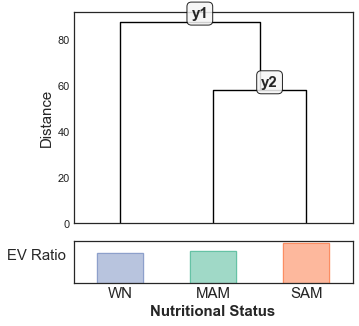

In [26]:
# Determine data-driven hierarchical structure 
topology = sy.Topology(ds_perturbations.X.copy(), ds_perturbations.y.copy(), class_type="status", obsv_type="perturbation", attr_type="edge", class_colors=colors_status.class_colors) #ds_perturbations.X is equivalent to ds_perturbations[None] because theres only one version
fig, _ = topology.plot_topology(figsize=(5,5))
fig.axes[-1].set_xlabel("Nutritional Status", fontsize=15, fontweight="bold")

In [27]:
# Set up directories for running Clairvoyance feature selection
submodel_data = defaultdict(dict)
for submodel, y_submodel in topology.get_target_matrix().T.iterrows():
    y_submodel = y_submodel.dropna()
    X_submodel = ds_perturbations.X.loc[y_submodel.index]
    subjects = sorted(ds_perturbations.metadata_observations.loc[X_submodel.index,  "SubjectID(Alias)"].unique())
    
    # Get LSOCV pairs
    cv_pairs = defaultdict(dict)
    for id_subject in subjects:
        mask = X_submodel.index.map(lambda id_visit: ds_perturbations.metadata_observations.loc[id_visit, "SubjectID(Alias)"] == id_subject)
        idx_te = np.where(mask)[0]
        idx_tr = np.delete(sy.utils.range_like(mask), idx_te)
        cv_pairs[id_subject]["Training"] = idx_tr.tolist()
        cv_pairs[id_subject]["Testing"] = idx_te.tolist()
        # Assert that each test set has samples from one subject.  This is set up so the training data has not seen this subject before
        assert ds_perturbations.metadata_observations.loc[y_submodel.index[idx_te], "SubjectID(Alias)"].nunique() == 1, "{} is not homogenous for subject".format(id_subject)
        
    # Format dataframes
    cv_submodel = pd.DataFrame(cv_pairs).T.loc[:,["Training", "Testing"]]
    cv_submodel.index.name = "VisitID"
    submodel_data[submodel]["cv"] = cv_submodel
    submodel_data[submodel]["X"] = X_submodel
    submodel_data[submodel]["y"] = y_submodel
    
#     # Serialize the dataframes
#     os.makedirs("./Data/modeling/", exist_ok=True)
#     sy.io.write_dataframe(X_submodel, "./Data/feature_selection/X.pbz2".format(submodel))
#     sy.io.write_dataframe(y_submodel.to_frame(), "./Data/feature_selection/{}/y.pbz2".format(submodel))
#     sy.io.write_dataframe(df_cv, "./Data/feature_selection/{}/cv.tsv".format(submodel))

#### Bash script for running Clairvoyance on compute server
```bash
source activate soothsayer_env
VERSION="v5.0"
SUBMODEL="y1" # The same command was run for all sub-models
NAME="${VERSION}_${SUBMODEL}"
X="X.pbz2"
y="y.pbz2"

python ~/soothsayer/standalone/soothsayer_clairvoyance.py \
                -X ${X} \
                -y ${y} \
                --cv 10 \
                --model_type logistic,tree \
                --n_iter 500 \
                --name ${NAME} \
                --min_threshold None,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9 \
                --percentiles 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99 \
                --method bruteforce  \
                --early_stopping 100 \
                --out_dir clairvoyance_output \
                --attr_type edge \
                --class_type status \
                --n_jobs 48 \
                --save_model False
```

#### Notes about change in LogisticRegression default solver between v0.21-v0.22: 
*Clairvoyance* was originally run on this dataset using *scikit-learn v0.21* where the default [**LogisticRegression(v0.21)**](https://scikit-learn.org/0.21/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) was `liblinear`.

The current [LogisticRegression(v0.23)](https://scikit-learn.org/0.23/modules/generated/sklearn.linear_model.LogisticRegression.html) default solver is `lbfgs`.  

This means the models were optimized using the `liblinear` solver and we need to manually set the solver when instantiating the models. 



In [28]:
# Load in Clairvoyance data
clairvoyance_data = defaultdict(dict)
param_defaults = dict(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
for submodel in topology.submodels: # ["y1", "y2"]
    path = "./Data/feature_selection/{}/v5.0_{}__synopsis/v5.0_{}__synopsis.tsv".format(submodel, submodel, submodel)
    
    # Load in the synopsis and evaluate the hyperparameter and edge_set columns because these are actually python objects
    df_synopsis = sy.io.read_dataframe(path, evaluate_columns=["hyperparameters", "edge_set"])
    df_synopsis["edge_set"] = df_synopsis["edge_set"].map(lambda x:list(map(eval, x)))
    clairvoyance_data[submodel]["synopsis"] =  df_synopsis
    
    # Determine best sub-model configurations
    best_params = sy.feature_extraction.get_best_model_from_algorithm(df_synopsis, into=dict)
    clairvoyance_data[submodel].update(best_params)
    
    # Get edge set
    edge_set = pd.Index(sorted(clairvoyance_data[submodel]["features"]))
    clairvoyance_data[submodel]["features"] = clairvoyance_data[submodel]["edges"] = edge_set
    
    # Get nodes from edge set
    node_set = pd.Index(sorted(sy.utils.flatten(edge_set, set)))
    clairvoyance_data[submodel]["nodes"] = node_set
    
    # Performance
    clf_submodel = clairvoyance_data[submodel]["clf"] 
    clf_submodel.set_params(solver = "liblinear") # See note in above cell

    # Get training, testing, and cross-validation data
    X_submodel = submodel_data[submodel]["X"].loc[:,clairvoyance_data[submodel]["edges"]]
    y_submodel =  submodel_data[submodel]["y"]
    cv_submodel = submodel_data[submodel]["cv"]
    
    # Cross-validate using LSOCV pairs
    for id_subject, (idx_tr, idx_te) in cv_submodel.iterrows():
        # Assert that each test set has samples from one subject.  This is set up so the training data has not seen this subject before
        assert ds_perturbations.metadata_observations.loc[y_submodel.index[idx_te],"SubjectID(Alias)"].nunique() == 1, "{} is not homogenous for subject".format(id_subject)
    clairvoyance_data[submodel]["cross_validation"] = pd.Series(model_selection.cross_val_score(estimator=clf_submodel,
                                    X=X_submodel.values, 
                                    y=y_submodel.values, 
                                    cv=cv_submodel.values.tolist(),
                                    n_jobs=1,
    ), index=cv_submodel.index, name=submodel)
    print("Sub-model({}) has LSOCV accuracy of {}".format(submodel, clairvoyance_data[submodel]["cross_validation"].mean()))
    
    # Fit
    clairvoyance_data[submodel]["clf"] = clf_submodel.fit(X_submodel, y_submodel)


Sub-model(y1) has LSOCV accuracy of 1.0
Sub-model(y2) has LSOCV accuracy of 1.0


/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/soothsayer/feature_extraction/feature_extraction.py:66: UserWarning: Multiple instances with best accuracy, lowest sem, and number of features.  Choosing first option.
  warnings.warn(multiple_hits_message)
/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/soothsayer/feature_extraction/feature_extraction.py:74: UserWarning: Multiple instances with best accuracy, lowest sem, and number of features.  Choosing first option.
  warnings.warn(multiple_hits_message)


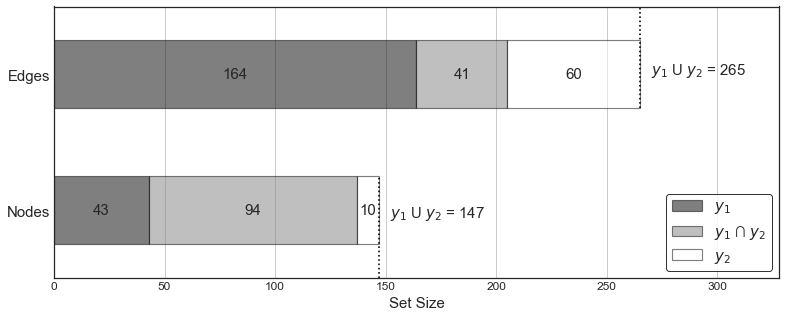

In [29]:
# Set comprehension
y1_edges = set(clairvoyance_data["y1"]["edges"]) - set(clairvoyance_data["y2"]["edges"])
y2_edges = set(clairvoyance_data["y2"]["edges"]) - set(clairvoyance_data["y1"]["edges"])
y1_nodes = set(clairvoyance_data["y1"]["nodes"]) - set(clairvoyance_data["y2"]["nodes"])
y2_nodes = set(clairvoyance_data["y2"]["nodes"]) - set(clairvoyance_data["y1"]["nodes"])
nodes_consensus = set(clairvoyance_data["y1"]["nodes"]) & set(clairvoyance_data["y2"]["nodes"])
edges_consensus = set(clairvoyance_data["y1"]["edges"]) & set(clairvoyance_data["y2"]["edges"])
nodes_union = set(clairvoyance_data["y1"]["nodes"]) | set(clairvoyance_data["y2"]["nodes"])
edges_union = set(clairvoyance_data["y1"]["edges"]) | set(clairvoyance_data["y2"]["edges"])

# Organize data to plot bar-chart-styled venn diagram
df = pd.DataFrame(
    {
    "Nodes":{"${y_1}$": len(y1_nodes), "${y_1}$ ∩ ${y_2}$":len(nodes_consensus), "${y_2}$":len(y2_nodes)},
    "Edges":{"${y_1}$": len(y1_edges), "${y_1}$ ∩ ${y_2}$":len(edges_consensus), "${y_2}$":len(y2_edges)},
})

# Plot stacked barchart
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(13,5))
    # Barchart
    df.T.plot(kind="barh", stacked=True, ax=ax, cmap="gray", edgecolor="black", linewidth=1.1618, alpha=0.5)
    ax.set_xlabel("Set Size", fontsize=15)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, rotation=0)
    ax.set_xticklabels(map(int,ax.get_xticks()), fontsize=12, rotation=0)
    # Draw lines for union of nodes/edges
    ax.plot( [len(nodes_union), len(nodes_union)], [min(ax.get_ylim()),0.25], color="black", linewidth=1.618, linestyle=":")
    ax.text( len(nodes_union)+5, -0.05, "${y_1}$ U ${y_2}$ = %d"%(len(nodes_union)), ha="left", fontsize=15)
    ax.plot( [len(edges_union), len(edges_union)],[0.75,max(ax.get_xlim())], color="black", linewidth=1.618, linestyle=":")
    ax.text(len(edges_union)+5, 1, "${y_1}$ U ${y_2}$ = %d"%(len(edges_union)), ha="left", fontsize=15)
    ax.xaxis.grid(True)
    # Plot annotations
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                int(width), 
                horizontalalignment='center', 
                verticalalignment='center',
                fontsize=15,
               )
    # Legend
    ax.legend(**{'fontsize': 15,
             'frameon': True,
             'facecolor': 'white',
             'edgecolor': 'black',
             'loc': 'lower right',
            })
    ax.set_xlim((min(ax.get_xlim()), max(ax.get_xlim())+50))    

## Hierarchical Ensemble of Classifiers Model

In [30]:
# Set up training data
X_training = ds_perturbations.X
Y_training = topology.get_target_matrix().loc[X_training.index]
y_training = topology.y[X_training.index]

# Create dataset
ds_training = sy.Dataset(
    data=X_training, 
    metadata_observations=Y_training,
    name="HEC",
)

# Add sub-model subsets as versions
for submodel in topology.submodels:
    
    X_submodel = submodel_data[submodel]["X"]
    y_submodel = submodel_data[submodel]["y"]
    cv_submodel = submodel_data[submodel]["cv"]
    
    # Training data
    ds_training.add_version(
        name_version=submodel, 
        data=submodel_data[submodel]["X"],
        X=X_submodel,
        y=y_submodel,
        cv_labels=cv_submodel.index,
        cv=cv_submodel.values.tolist(),
        clf=clairvoyance_data[submodel]["clf"],
        features=clairvoyance_data[submodel]["features"],
        edges=clairvoyance_data[submodel]["edges"],
        nodes=clairvoyance_data[submodel]["nodes"],
        hyperparameters=clairvoyance_data[submodel]["hyperparameters"],
    )
    

In [31]:
# Create the HEC model
model = HEC(
    name="v5.0", 
    attr_type="edge", 
    obsv_type="sample", 
    class_type="nutritional_status", 
    verbose=True
)


# Add paths in the graph
paths = topology.get_paths()
model.add_paths(topology.get_paths())

# -------------------------------------------------
# Model fitting and cross-validation [Full Dataset]
# -------------------------------------------------
# Add submodels to HEC
for submodel in topology.submodels:
    # Training data
    X_submodel = ds_training.get_dataset_field(submodel, "X")
    y_submodel = ds_training.get_dataset_field(submodel, "y")
    
    # Clairvoyance-optimized gene sets
    features = ds_training.get_dataset_field(submodel, "features") # Let's keep it agnostic to biological concepts at this point
    
    # Logistic Regression sub-models with hyperparameters defined earlier
    clf = ds_training.get_dataset_field(submodel, "clf")
    
    # Custom cross-validation pairs
    cv_labels = ds_training.get_dataset_field(submodel, "cv_labels")
    cv = ds_training.get_dataset_field(submodel, "cv")
    index = X_submodel.index
    
    # Add sub-model
    model.add_submodel(name=submodel, clf=clf, attributes=features.tolist(), cv=cv, index=index, cv_labels=cv_labels)
    
    # Fit sub-model
    model.get_classifier(submodel).fit(X_submodel.loc[:,features], y_submodel)
    
# Fit the model using the attribute and target matrices
model.fit(X_training, Y_training)

# Evaluate the model
print("HEC model LSOCV accuracy", model.cross_validate(X_training, Y_training).mean())#, mode="directional" )


# # Save model
# model.save_model(path="./Data/HEC.pkl") # Will probably change this to .to_file in future versions

# # Load model
# model = sy.io.read_object("./Data/HEC.pkl")

Cross-validating: 34it [00:00, 37.70it/s]

HEC model LSOCV accuracy 1.0


In [32]:
# Manually cross-validate the HEC model
root_submodel = model.root_submodel
assert root_submodel == "y1", "`root_submodel` should be 'y1'" #root_submodel = "y1". Using `y1` b/c it is the root decision that all of the data passes through in the HEC
Y_hats = list()
for (cross_validation_label, (idx_tr, idx_te)) in tqdm(zip(ds_training.get_dataset_field(root_submodel, "cv_labels"), ds_training.get_dataset_field(root_submodel, "cv")), "Manual cross-validation"): 
    # Partition training/testing sets
    X_tr = X_training.iloc[idx_tr,:]
    X_te = X_training.iloc[idx_te,:]
    Y_tr = Y_training.iloc[idx_tr,:]
    Y_te = Y_training.iloc[idx_te,:]
    
    # Fit model
    model.fit(X_tr, Y_tr, ignore_submodel_index=True) # Use `ignore_submodel_index` when manually cross-validating
    
    # Get probabilities per sub-model
    Y_hat = model.predict_proba(X_te )
    Y_hats.append(Y_hat)
Y_hats = pd.concat(Y_hats)

Manual cross-validation: 34it [00:00, 36.55it/s]


In [33]:
model.get_classifier("y1").classes_

array(['WN', 'y2'], dtype=object)

## Interpreting the HEC model

In [34]:
# Extract fitted edges weights per sub-model
df_AN_connectivity__edges = dict()#pd.DataFrame()

for submodel in model.submodels:
    edge_weights = pd.Series(clairvoyance_data[submodel]["clf"].coef_.ravel(), index=clairvoyance_data[submodel]["features"], name=submodel)
    df_AN_connectivity__edges[(submodel, "Weight")] = edge_weights.to_dict() # Note: Can use this when not manually cross-validating submodels within the model object: pd.Series(model.get_classifier(submodel).coef_.flatten(), index=model.get_attributes(submodel), name=submodel)
    df_AN_connectivity__edges[(submodel, "|Weight|")] = edge_weights.abs().to_dict()

# View the weights
df_AN_connectivity__edges = pd.DataFrame(df_AN_connectivity__edges)
df_AN_connectivity__edges.columns = pd.MultiIndex.from_tuples(df_AN_connectivity__edges.columns, names=["Sub-model", "Signed"])
df_AN_connectivity__edges.head()

Sub-model                     y1                  y2          
Signed                    Weight  |Weight|    Weight  |Weight|
(Otu000906, Otu000965) -0.483324  0.483324       NaN       NaN
(cortisol, Otu000965)   0.327551  0.327551  0.107654  0.107654
(Otu000035, Otu000101) -0.349000  0.349000 -0.124854  0.124854
(Otu000005, Otu000494) -0.421472  0.421472       NaN       NaN
(Otu000404, sobr)       0.410569  0.410569       NaN       NaN

Inferred association as `dissimilarity`
/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/soothsayer/ordination/ordination.py:74: UserWarning: Using `show_features` to create a `biplot` is experimental.
  warnings.warn("Using `show_features` to create a `biplot` is experimental.")
Selected 4 features:
[('y1', 'WN'), ('y1', 'y2'), ('y2', 'MAM'), ('y2', 'SAM')]


(<Figure size 576x360 with 1 Axes>,
 <matplotlib.collections.PathCollection at 0x7fb08eded100>)

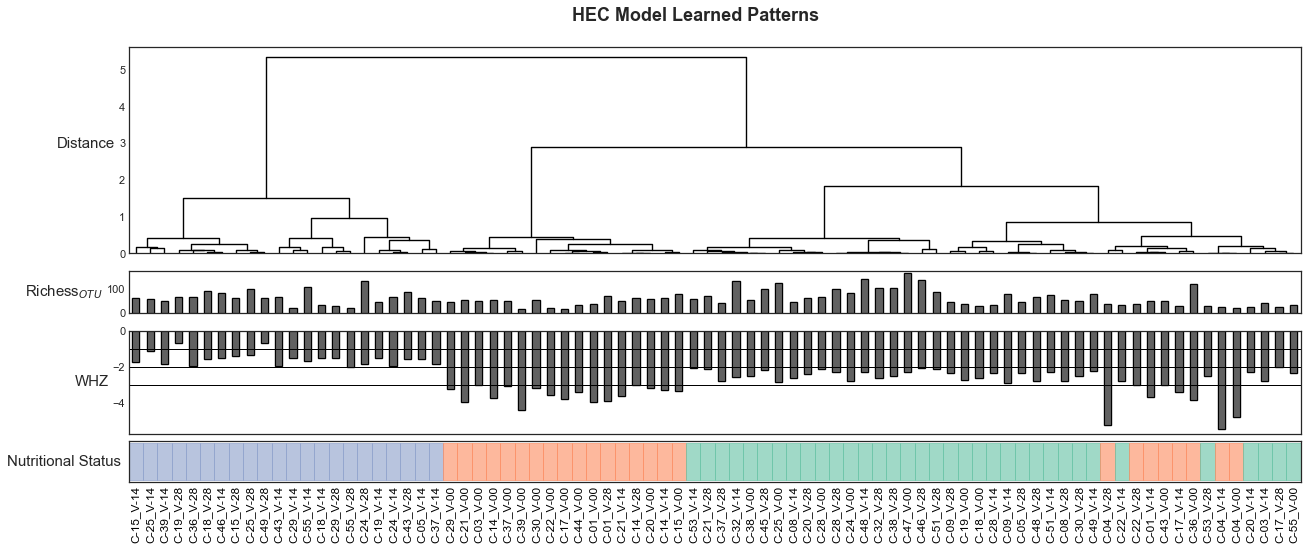

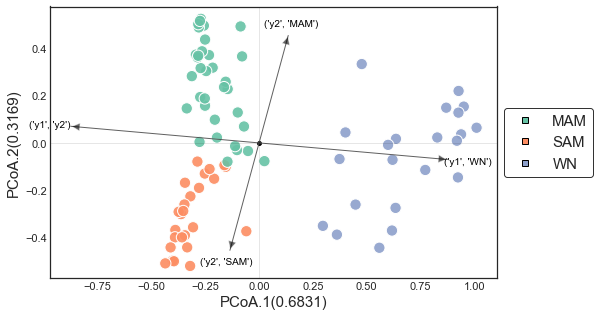

In [35]:
# Extracting the learned patterns by the HEC model
df_dism = sy.symmetry.pairwise(Y_hats, metric="euclidean", axis=0)

# Agglomerative hierarchical clustering
ahc = sy.Agglomerative(df_dism)
ahc.add_secondary_class("Nutritional Status", mapping=ds_perturbations.y, class_colors=colors_status.class_colors)
ahc.add_track("Richess$_{OTU}$", df_richness.loc[ahc.leaves, "OTU"].fillna(0))
ahc.add_track("WHZ", ds_perturbations.metadata_observations["WHZ"], horizontal_lines=[-1,-2,-3], percent_of_figure=50 )
ahc.plot( show_leaves=True, figsize=(21,8), show_track_ticks=True, title="HEC Model Learned Patterns")

# PCoA
sy.ordination.PrincipalCoordinatesAnalysis(df_dism, data=Y_hats).plot(show_features=True, color_arrow="black",color_feature="black", arrow_scale=2, c=colors_status.obsv_colors, figsize=(8,5), legend=colors_status.class_colors)

submodel              y1                  y2          
classification        WN        y2       MAM       SAM
query                                                 
C-01_V-14       0.093151  0.906849  0.463333  0.536667
C-01_V-00       0.023380  0.976620  0.281919  0.718081
C-01_V-28       0.025484  0.974516  0.259720  0.740280
C-03_V-14       0.223036  0.776964  0.551767  0.448233
C-03_V-00       0.028831  0.971169  0.189608  0.810392
...                  ...       ...       ...       ...
C-53_V-28       0.161360  0.838640  0.509847  0.490153
C-53_V-14       0.032776  0.967224  0.859731  0.140269
C-55_V-14       0.726638  0.273362  0.388917  0.611083
C-55_V-00       0.178955  0.821045  0.559754  0.440246
C-55_V-28       0.500266  0.499734  0.368091  0.631909

[82 rows x 4 columns]

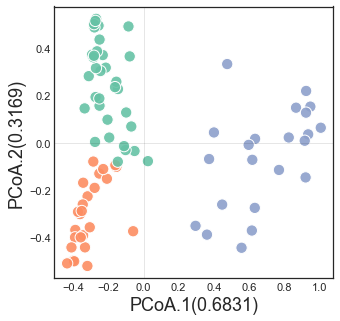

In [36]:
fig, ax, im = sy.ordination.PrincipalCoordinatesAnalysis(df_dism, data=Y_hats).plot(show_features=False, color_arrow="black",color_feature="black", arrow_scale=2, c=colors_status.obsv_colors, figsize=(5,5))
                                         
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)

Y_hats
# submodel	y1	y2
# classification	WN	y2	MAM	SAM
# query				
# C-01_V-14	0.093151	0.906849	0.463333	0.536667
# C-01_V-00	0.023380	0.976620	0.281919	0.718081
# C-01_V-28	0.025484	0.974516	0.259720	0.740280
# C-03_V-14	0.223036	0.776964	0.551767	0.448233
# C-03_V-00	0.028831	0.971169	0.189608	0.810392
# ...	...	...	...	...
# C-53_V-28	0.161360	0.838640	0.509847	0.490153
# C-53_V-14	0.032776	0.967224	0.859731	0.140269
# C-55_V-14	0.726638	0.273362	0.388917	0.611083
# C-55_V-00	0.178955	0.821045	0.559754	0.440246
# C-55_V-28	0.500266	0.499734	0.368091	0.631909

## Aggregate networks

<ipython-input-37-0fd3101bf651>:12: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  for node in sy.utils.flatten(clairvoyance_data["y1"]["edges"] | clairvoyance_data["y2"]["edges"], set):


(147, 4) (265, 4)


Sub-model                     y1                  y2          
Signed                    Weight  |Weight|    Weight  |Weight|
(Otu000906, Otu000965) -0.483324  0.483324       NaN       NaN
(cortisol, Otu000965)   0.327551  0.327551  0.107654  0.107654
(Otu000035, Otu000101) -0.349000  0.349000 -0.124854  0.124854
(Otu000005, Otu000494) -0.421472  0.421472       NaN       NaN
(Otu000404, sobr)       0.410569  0.410569       NaN       NaN

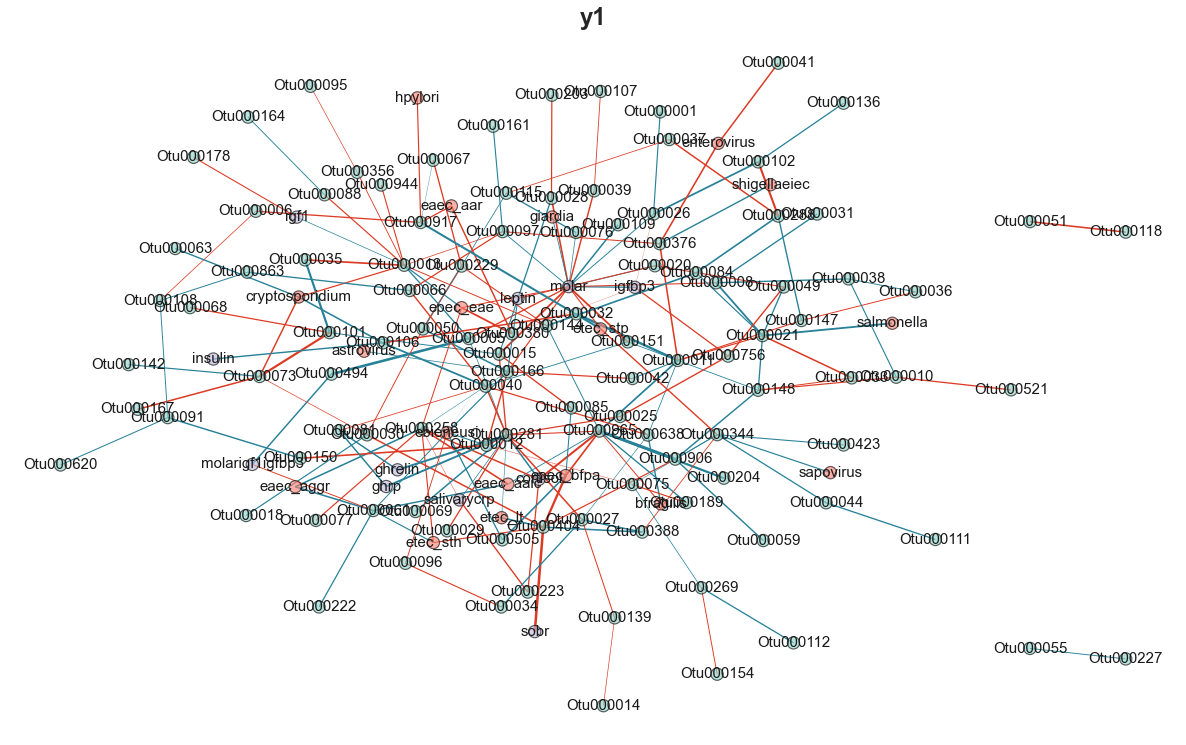

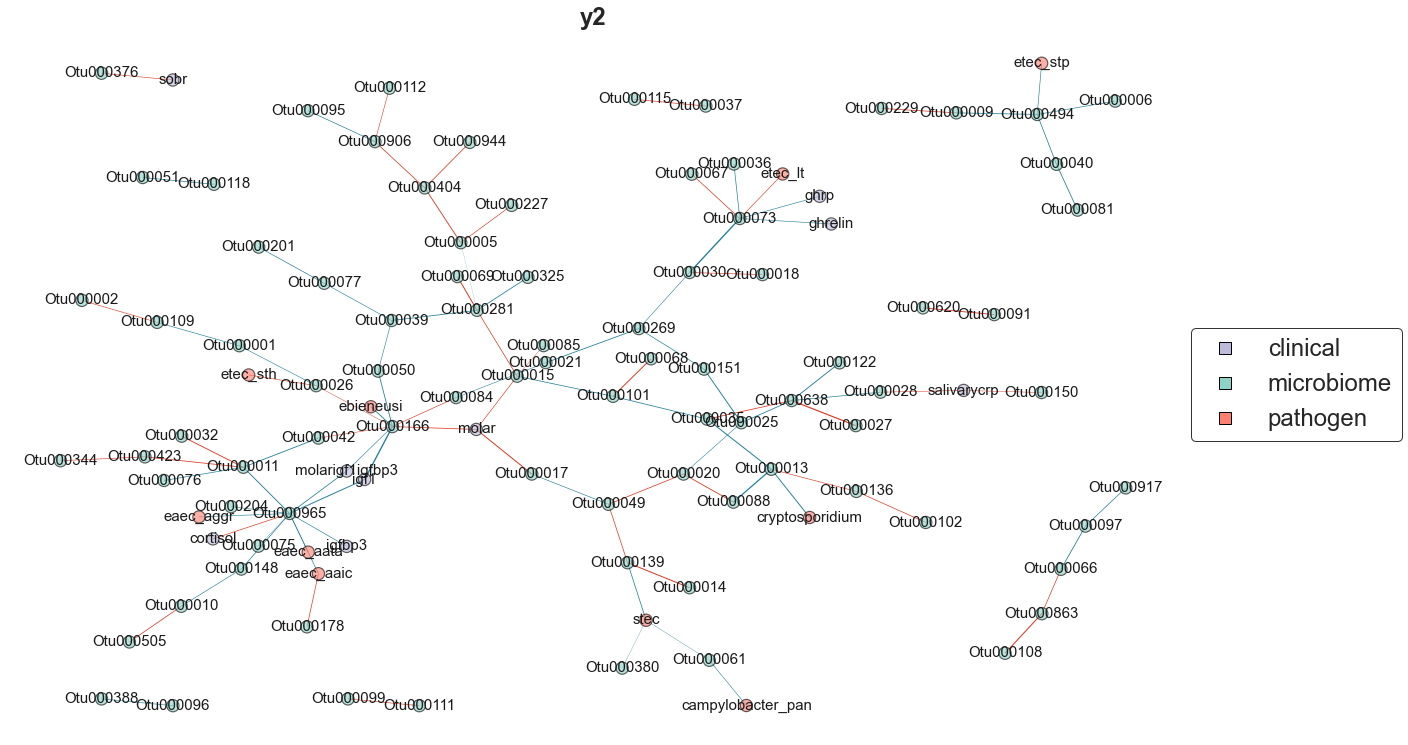

In [37]:
# Node metadata
def f(x):
    modality = y_modality[x]
    if modality == "microbiome":
        return "|".join(ds_otus.metadata_attributes.loc[x, ['Domain','Phylum', 'Class', 'Order','Family', 'Genus', 'Species']])
    else:
        return  df_descriptions.loc[x, "Description"]

df_descriptions = sy.io.read_dataframe("./Data/clinical-pathogen_descriptions.tsv")

data = defaultdict(dict)
for node in sy.utils.flatten(clairvoyance_data["y1"]["edges"] | clairvoyance_data["y2"]["edges"], set):
    for submodel in ["y1", "y2"]:
        data[node]["AN_{}".format(submodel)] = node in clairvoyance_data[submodel]["nodes"]
        
df_meta_nodes = pd.DataFrame(data).T.sort_index()
df_meta_nodes["In_Aggregate_Network"] = True
df_meta_nodes = df_meta_nodes.reindex(ds_multimodal["residuals"].columns)
df_meta_nodes["In_Aggregate_Network"] = df_meta_nodes["In_Aggregate_Network"].fillna(False)
df_meta_nodes = df_meta_nodes.fillna(False)

# df_meta_nodes = pd.concat([df_meta_nodes, ds_otus.metadata_attributes.loc[df_meta_nodes.index & ds_otus.metadata_attributes.index,['Taxonomy','Phylum', 'Class', 'Order','Family', 'Genus', 'Species']]], axis=1)
# df_meta_nodes.loc[df_descriptions.index & df_meta_nodes.index, "Description"] = df_descriptions["Description"]

# df_descriptions.loc[ds_clinicals["aggregated"].columns | ds_pathogens["aggregated"].columns,"Description"]
df_meta_nodes["Description"] = df_meta_nodes.index.map(f)
df_meta_nodes


# Aggregate Networks
df_AN_connectivity__nodes = dict()
for submodel in model.submodels:
    
    # Create aggregate network for each sub-model
    edge_weights = df_AN_connectivity__edges[(submodel, "Weight")].dropna()#[lambda w: w != 0] 
    graph = nx.Graph(name=submodel)
    for edge, w in edge_weights.items():
        edge = tuple(edge)
        graph.add_edge(*edge, weight=abs(w), sign=np.sign(w))
    
    # Node connectivity
    node_weights = pd.Series(dict(nx.degree(graph, weight="weight"))) # Weighted degree
    df_AN_connectivity__nodes[(submodel, "Connectivity(weighted-degree)")] = node_weights.to_dict()
    df_AN_connectivity__nodes[(submodel, "Connectivity(weighted-degree_scaled)")] = (node_weights/node_weights.sum()).to_dict()
    
    # Get positions
    pos = nx.nx_agraph.graphviz_layout(graph, prog="neato")
    coefs = edge_weights[list(map(frozenset, graph.edges()))]
    edgecolors = coefs.map(lambda x: {True:sy.utils.COLOR_POSITIVE, False: sy.utils.COLOR_NEGATIVE}[x > 0])
    edge_widths = coefs.abs()*6.18
    with plt.style.context("seaborn-white"):
        fig, ax = plt.subplots(figsize=(21,13))
        nx.draw_networkx_nodes(graph, pos=pos, alpha=0.618,node_size=150, edgecolors="black", linewidths=1.1618, ax=ax, node_color=colors_modality.obsv_colors[list(graph.nodes())])
        nx.draw_networkx_edges(graph, pos=pos, ax=ax, style="-", width=edge_widths, edge_color=edgecolors)
        nx.draw_networkx_labels(graph, labels=dict(zip(graph.nodes(), graph.nodes())), pos=pos, ax=ax,  font_size=15)
        ax.axis("off")
        if submodel == "y2":
            legend_kws = sy.utils.LEGEND_KWS
            legend_kws["fontsize"] = 24
            ax.legend(*sy.utils.format_mpl_legend_handles(colors_modality.class_colors),  **legend_kws)
        ax.set_title("{}".format(submodel), fontsize=24, fontweight="bold")
#     # Save
#     sy.io.write_object(graph, "./Data/AN_{}.graph.networkx.pkl".format(submodel))
#     sy.io.write_object(pos, "./Data/AN_{}.pos.dict.pkl".format(submodel))


# Set multiindex
df_AN_connectivity__nodes = pd.DataFrame(df_AN_connectivity__nodes)
df_AN_connectivity__nodes.columns = pd.MultiIndex.from_tuples(df_AN_connectivity__nodes.columns, names=["Sub-model", "Scaled"])

# View edge metadata
print(df_AN_connectivity__nodes.shape, df_AN_connectivity__edges.shape)
df_AN_connectivity__edges.head()

# 	AN_y1	AN_y2	In_Aggregate_Network	Description
# Otu000009	False	True	True	Bacteria|Bacteroidetes|Bacteroidia|Bacteroidal...
# Otu000040	True	True	True	Bacteria|Bacteroidetes|Bacteroidia|Bacteroidal...
# Otu000037	True	True	True	Bacteria|Bacteroidetes|Bacteroidia|Bacteroidal...
# Otu000002	False	True	True	Bacteria|Firmicutes|Clostridia|Clostridiales|R...
# Otu000067	True	True	True	Bacteria|Bacteroidetes|Bacteroidia|Bacteroidal...
# ...	...	...	...	...
# norovirus	False	False	False	Norovirus
# salmonella	True	False	True	Salmonella
# sapovirus	True	False	True	Sapovirus
# shigellaeiec	True	False	True	Shigella/Enteroinvasive Escherichia coli
# stec	False	True	True	Shiga toxin-producing Escherichia coli

# Sub-model	y1	y2
# Signed	Weight	|Weight|	Weight	|Weight|
# (Otu000965, Otu000906)	-0.483324	0.483324	NaN	NaN
# (cortisol, Otu000965)	0.327551	0.327551	0.107654	0.107654
# (Otu000101, Otu000035)	-0.349000	0.349000	-0.124854	0.124854
# (Otu000005, Otu000494)	-0.421472	0.421472	NaN	NaN
# (Otu000404, sobr)	0.410569	0.410569	NaN	NaN

<ipython-input-38-535c33320612>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  nodes = sorted(index & sym.nodes)
/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/hive_networkx/hive_networkx.py:765: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index_labels = pd.Index(show_node_labels) & index_labels
<ipython-input-38-535c33320612>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  nodes = sorted(index & sym.nodes)
/Users/jespinoz/anaconda3/envs/soothsayer_py3.8_env/lib/python3.8/site-packages/hive_networkx/hive_networkx.py:765: FutureWarning

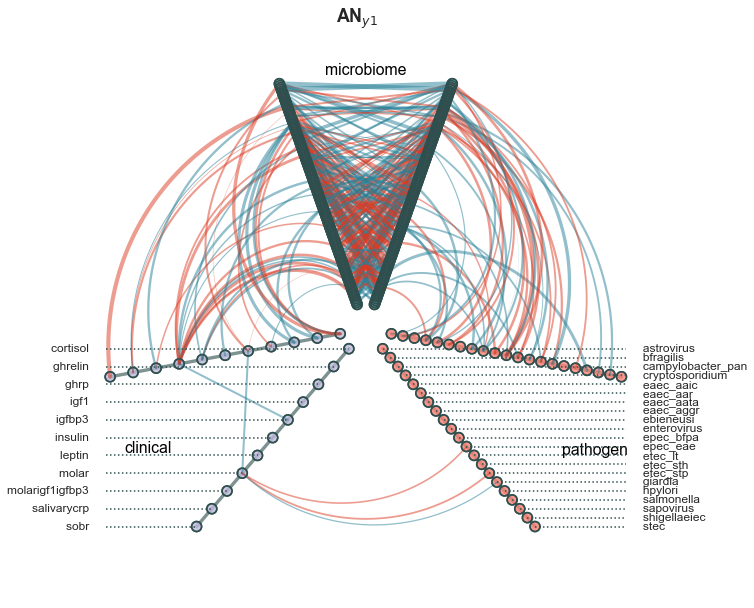

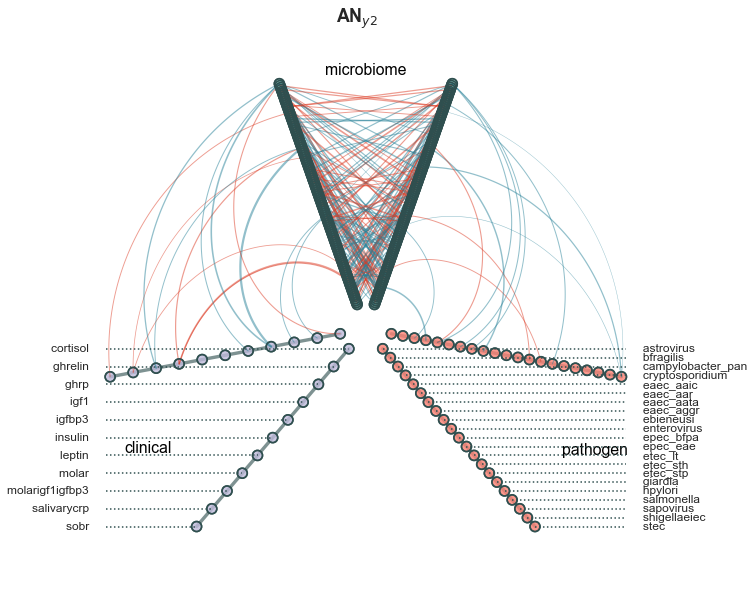

In [38]:
# Hive plots
aggregate_networks = dict()
for submodel in model.submodels:
    # Create a full-connected network to use as input for hive plots
    sym = hx.Symmetric(df_AN_connectivity__edges[(submodel, "Weight")])
    # Fill the empty edge weights with zeros
    sym.weights = sym.weights.fillna(0)
    aggregate_networks[submodel] = sym
    # Get colors for edges based on sign
    edge_colors = sym.weights.map(lambda x:{True:sy.utils.COLOR_POSITIVE, False:sy.utils.COLOR_NEGATIVE}[x>0])
    # Create Hive
    hive = hx.Hive(sym, name=submodel)
    # Get non-microbiome nodes to label (there are too many OTUs to label)
    show_node_labels = sy.utils.flatten(sym.weights.index[sym.weights.index.map(lambda edge: list(map(lambda node: y_modality[node], edge)).count("microbiome") < 1)], set)
    # Add each modality as an axis
    for modality, index in sorted(sy.utils.pd_series_collapse(y_modality, type_collection=pd.Index).items(), key=lambda x:{"microbiome":0, "clinical":1, "pathogen":2}[x[0]]):
        nodes = sorted(index & sym.nodes)
        hive.add_axis(name_axis=modality, nodes=nodes, colors=colors_modality.class_colors[modality], split_axis=True)
    hive.compile(inner_radius=100)
    # Plot the hive
    hive.plot(style="white", edge_colors=edge_colors, func_edgeweight=lambda w:w*10, show_node_labels=show_node_labels, figsize=(10,10), pad_axis_label=-150, title="AN$_{%s}$"%(submodel))

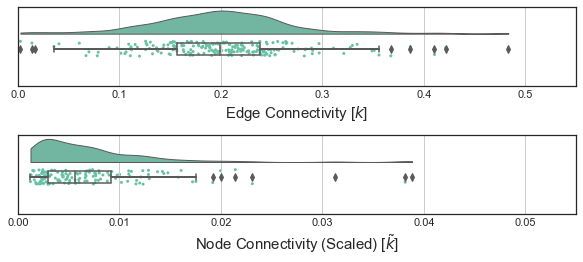

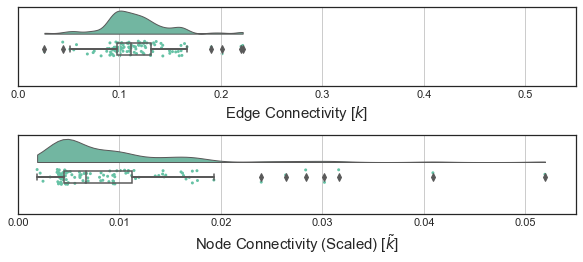

In [39]:
# Connectivity plots
with plt.style.context("seaborn-white"):
    for submodel in model.submodels:
        fig, axes = plt.subplots(figsize=(10, 3.82), nrows=2, gridspec_kw={"hspace":0.618})
        # Edge connectivity
        ax=axes[0]
        edge_weights = df_AN_connectivity__edges[(submodel,"|Weight|")]
        pt.RainCloud(x=edge_weights, orient="horizontal", ax=ax, width_box=0.1618, width_viol=0.618)
        ax.xaxis.grid(True)
        ax.set_xlabel("Edge Connectivity [$k$]", fontsize=15)
        ax.set_xlim((0,0.55))
        # Node connectivity
        ax = axes[1]
        node_weights = df_AN_connectivity__nodes[(submodel,"Connectivity(weighted-degree_scaled)")]
        pt.RainCloud(x=node_weights, orient="horizontal", ax=ax, width_box=0.1618, width_viol=0.618)
        ax.xaxis.grid(True)
        ax.set_xlabel(r"Node Connectivity (Scaled) [$\tilde{k}$]", fontsize=15)
        ax.set_xlim((0,0.055))

,Taxonomy,Confidence,Life,Domain,Phylum,Class,Order,Family,Genus,Species
Otu000015,Root;Bacteria;Firmicutes;Bacilli;Lactobacillal...,1.00,Root,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,Lactobacillus_mucosae
Otu000151,Root;Bacteria;Proteobacteria;Gammaproteobacter...,1.00,Root,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Haemophilus,unclassified_Haemophilus
Otu000028,Root;Bacteria;Firmicutes;Clostridia;Clostridia...,0.91,Root,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae_UCG-002,unclassified_Ruminococcaceae_UCG-002
Otu000109,Root;Bacteria;Proteobacteria;Gammaproteobacter...,0.86,Root,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Proteus,Proteus_mirabilis
Otu000039,Root;Bacteria;Firmicutes;Bacilli;Lactobacillal...,1.00,Root,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,unclassified_Lactobacillus
Otu000005,Root;Bacteria;Firmicutes;Bacilli;Lactobacillal...,1.00,Root,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,unclassified_Enterococcus
igfbp3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Otu000166,Root;Bacteria;Proteobacteria;Gammaproteobacter...,1.00,Root,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,unclassified_Enterobacteriaceae,unclassified_Enterobacteriaceae
etec_stp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Otu000008,Root;Bacteria;Firmicutes;Bacilli;Lactobacillal...,1.00,Root,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,Lactobacillus_ruminis


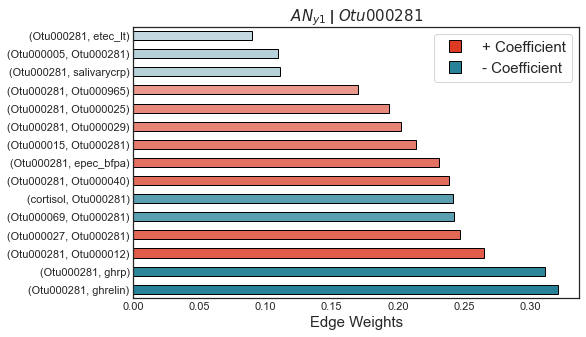

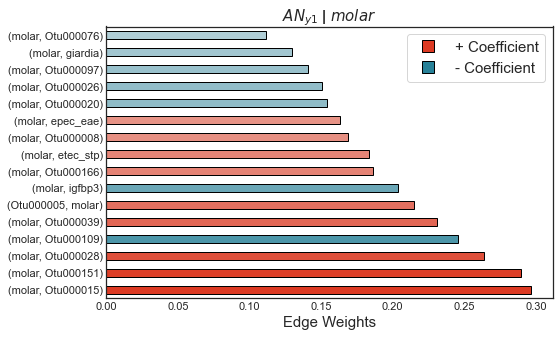

In [40]:
# High connectivity nodes
y1_weights__signed = df_AN_connectivity__edges[("y1","Weight")].dropna().sort_values(ascending=False)
y1_weights = y1_weights__signed.abs().sort_values(ascending=False)

y2_weights__signed = df_AN_connectivity__edges[("y2","Weight")].dropna().sort_values(ascending=False)
y2_weights = y2_weights__signed.abs().sort_values(ascending=False)
# y1_weights.mean(), y2_weights.mean(), y1_weights.sum(), y2_weights.sum()

# Otu000281
node = "Otu000281"
z = y1_weights[y1_weights.index.map(lambda x: node in x)].sort_values(ascending=False)
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(8,5))
    z.plot(kind="barh", color=sy.utils.map_colors(y1_weights__signed[z.index],mode=3, cmap=sy.utils.CMAP_DIVERGING, vmin=-z.max(), vmax=z.max(), format="hex"), linewidth=1, edgecolor="black", ax=ax)
    ax.set_xlabel("Edge Weights", fontsize=15)
    ax.set_title("$AN_{y1}$ | $%s$"%(node), fontsize=15, fontweight="bold")
    ax.legend(*sy.utils.format_mpl_legend_handles({"+ Coefficient":sy.utils.COLOR_POSITIVE, "- Coefficient":sy.utils.COLOR_NEGATIVE}), fontsize=15, frameon=True, markerscale=2)

# molar
node = "molar"
z = y1_weights[y1_weights.index.map(lambda x: node in x)].sort_values(ascending=False)
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(8,5))
    z.plot(kind="barh", color=sy.utils.map_colors(y1_weights__signed[z.index],mode=3, cmap=sy.utils.CMAP_DIVERGING, vmin=-z.max(), vmax=z.max(), format="hex"),  linewidth=1, edgecolor="black", ax=ax)
    ax.set_xlabel("Edge Weights", fontsize=15)
    ax.set_title("$AN_{y1}$ | $%s$"%(node), fontsize=15, fontweight="bold")
    ax.legend(*sy.utils.format_mpl_legend_handles({"+ Coefficient":sy.utils.COLOR_POSITIVE, "- Coefficient":sy.utils.COLOR_NEGATIVE}), fontsize=15, frameon=True, markerscale=2)
    
z_copy = z.copy()
z_copy.index = z_copy.index.map(lambda x: list(set(x) - {"molar"})[0])
ds_otus.m1.reindex(z_copy.index)




In [41]:
# AN Connectivity statistics
d = dict()

for AN in ["y1", "y2"]:
    d[AN] = {
        "Total Connectivity [$k$]":df_AN_connectivity__edges[(AN, "|Weight|")].dropna().sum(),
        "µ$_{edges}$ [$k$]":df_AN_connectivity__edges[(AN, "|Weight|")].dropna().mean(),
        "µ$_{nodes}$ [$\tilde{k}$]":df_AN_connectivity__nodes[(AN, "Connectivity(weighted-degree_scaled)")].dropna().mean(),
        "skewness$_{edges}$":stats.skew(df_AN_connectivity__edges[(AN, "|Weight|")].dropna()),
        "skewness$_{nodes}$":stats.skew(df_AN_connectivity__nodes[(AN, "Connectivity(weighted-degree_scaled)")].dropna()),
    }
df_AN_connectivity__summarystats = pd.DataFrame(d)

AN_connectivity__mannwhitney = pd.Series(
    {
        "Nodes": stats.mannwhitneyu(df_AN_connectivity__nodes[("y1", "Connectivity(weighted-degree_scaled)")].dropna(), df_AN_connectivity__nodes[("y2", "Connectivity(weighted-degree_scaled)")].dropna())[1],
        "Edges": stats.mannwhitneyu(df_AN_connectivity__edges[("y1", "|Weight|")].dropna(), df_AN_connectivity__edges[("y2", "|Weight|")].dropna())[1],
        
}
, name="Mannwhitney P-Value")
df_AN_connectivity__summarystats

# y1	y2
# Total Connectivity [ 𝑘 ]	41.033074	11.677944
# µ 𝑒𝑑𝑔𝑒𝑠  [ 𝑘 ]	0.200161	0.115623
# µ 𝑛𝑜𝑑𝑒𝑠  [ 𝑘̃  ]	0.007299	0.009615
# skewness 𝑒𝑑𝑔𝑒𝑠 	0.392351	0.611571
# skewness 𝑛𝑜𝑑𝑒𝑠 	2.506560	2.604756

,y1,y2
Total Connectivity [$k$],41.033074,11.677944
µ$_{edges}$ [$k$],0.200161,0.115623
µ$_{nodes}$ [$\tilde{k}$],0.007299,0.009615
skewness$_{edges}$,0.392351,0.611571
skewness$_{nodes}$,2.506560,2.604756


### Recovery Scores

In [42]:
# Recovery scores
def recovery_score(t_wn, t_u):
    a = np.abs(t_u - t_wn)
    b = np.abs(t_wn)
    z = a**2 / (6*b + 4)
    return z



recovery_events = defaultdict(list)
d = {"WN":0, "MAM":-1, "SAM":-2}
for id_subject, df in ds_perturbations.metadata_observations.groupby("SubjectID(Alias)"):
    df = df.sort_values("Visit[Day]")
    y = df["Nutritional_Status"]
    if y.nunique() > 1:
        for i in range(df.shape[0]-1):
            y_i = y.iloc[i]
            y_iplus1 = y.iloc[i+1]
            if d[y_iplus1] > d[y_i]:
                event = (y_i, y_iplus1)
                x = (y.index[i],  y.index[i+1])
                recovery_events[event].append(x)
                
X_recovery = dict()
y_recovery = dict()
for event, pairs in recovery_events.items():
    if "WN" in event:
        for sample_i, sample_iplus1 in pairs:
            # Get nutritional states
            y_i = ds_perturbations.metadata_observations.loc[sample_i, "Nutritional_Status"]
            y_iplus1 = ds_perturbations.metadata_observations.loc[sample_iplus1, "Nutritional_Status"] 
            
            # Assert pairs are correct
            assert y_i == event[0]
            assert y_iplus1 == event[1]
            assert y_i in {"MAM", "SAM"}
            assert y_iplus1 == "WN"
            
            # Perturbation Profiles
            t_undernourished = ds_perturbations.X.loc[sample_i,edges_union]
            t_wn = ds_perturbations.X.loc[sample_iplus1,edges_union]
            
            # Recovery scores
            X_recovery[(sample_i, sample_iplus1)] = recovery_score(t_wn, t_undernourished)
            y_recovery[(sample_i, sample_iplus1)] = event
            
X_recovery = pd.DataFrame(X_recovery).T
X_recovery.index.names = ["$t_n$", "$t_{n+1}$"]
y_recovery = pd.Series(y_recovery)


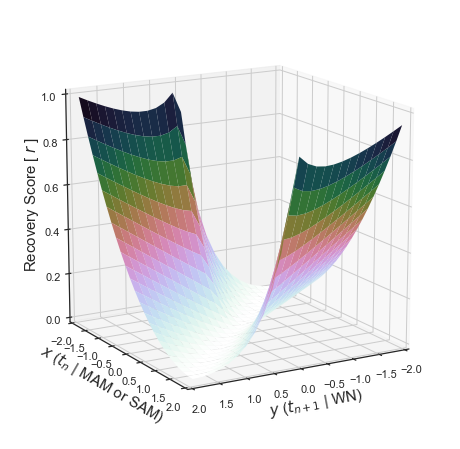

In [43]:


cmap = plt.cm.cubehelix_r
with plt.style.context("seaborn-white"):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')

    # Make data.
    steps = 0.1618
    X = np.arange(-2, 2, steps)
    Y = np.arange(-2, 2, steps)
    X, Y = np.meshgrid(X, Y)
    Z = recovery_score(X, Y)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cmap,rstride=1, cstride=1, 
                           linewidth=0, antialiased=True, shade=True, vmin=0, vmax=1)

    # Customize the z axis.

    ax.set_xlabel("$y$ ($t_{n+1}$ | WN)", fontsize=15)
    ax.set_ylabel("$x$ ($t_{n}$ | MAM or SAM)", fontsize=15)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel("Recovery Score [ $r$ ]", fontsize=15, rotation=90)
#     ax.plot(xs=[-2,2], ys=[-2,2], zs=[0,0], color="black", linewidth=1, alpha=0.618)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_zlim(0, 1.0)
    ax.view_init(15, 60)
    # Add a color bar which maps values to colors.
#     fig.colorbar(surf, aspect=5, shrink=0.5)#, shrink=0.25, aspect=5)



<ipython-input-44-31f9044cbf1e>:12: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'shade', 'linewidth'
  contour = ax.contourf(X, Y, Z, cmap=cmap,rstride=1, cstride=1, shade=True, levels=50,


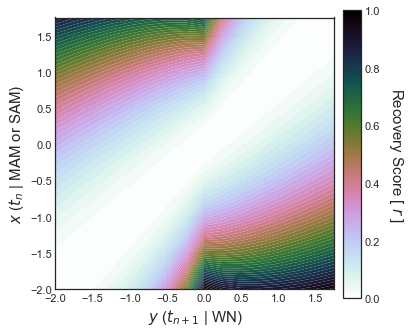

In [44]:

with plt.style.context("seaborn-white"):
    
    fig, ax = plt.subplots(figsize=(5,5))

    # Make data.
    X = np.arange(-2, 2, 0.25)
    Y = np.arange(-2, 2, 0.25)
    X, Y = np.meshgrid(X, Y)
    Z = recovery_score(X, Y)

    # Plot the surface.
    contour = ax.contourf(X, Y, Z, cmap=cmap,rstride=1, cstride=1, shade=True, levels=50,
                           linewidth=0.1, antialiased=True,vmin=0, vmax=1)

#     # Customize the z axis.
#     ax.set_zlim(0, 1.0)
#     ax.view_init(15, 60)
    ax.set_xlabel("$y$ ($t_{n+1}$ | WN)", fontsize=15)
    ax.set_ylabel("$x$ ($t_{n}$ | MAM or SAM)", fontsize=15)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
#     ax.axvline(0, color="black", linewidth=1, alpha=0.618)
#     ax.axhline(0, color="black")

#     ax.set_zlabel("Recovery Score", fontsize=15)

    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
#     fig.colorbar(contour, aspect=5, shrink=0.5)#, shrink=0.25, aspect=5)
    sy.utils.add_cbar_from_data(fig, cmap=cmap, vmin=0, vmax=1, cbar_pos=[0.925, 0.1, 0.05, 0.8], label="Recovery Score [ $r$ ]", cbar_kws={"fontsize":15})



MAM $\Rightarrow$ WN Q1: 0.003409561188708688 Q2: 0.060801546295432704 Q3: 0.18184486358787916 IQR: 0.17843530239917046 Outlier Range: (0.264243392410047, 0.44949781718663484)
SAM $\Rightarrow$ WN Q1: 0.002597084202842549 Q2: 0.0620588670544376 Q3: 0.18234513560757337 IQR: 0.17974805140473082 Outlier Range: (0.2670249929042537, 0.4519672127146696)


$t_n$      $t_{n+1}$  Edges                 
C-25_V-00  C-25_V-14  (Otu000091, Otu000150)    0.999682
C-36_V-00  C-36_V-28  (Otu000091, Otu000150)    0.999602
                      (Otu000055, Otu000227)    0.983754
C-49_V-14  C-49_V-28  (Otu000005, Otu000227)    0.983496
C-24_V-00  C-24_V-14  (Otu000095, Otu000906)    0.982887
                      (Otu000028, Otu000638)    0.969426
C-36_V-00  C-36_V-28  (Otu000108, Otu000091)    0.968867
                      (Otu000102, Otu000026)    0.965900
C-29_V-00  C-29_V-14  (Otu000050, Otu000166)    0.959686
C-15_V-00  C-15_V-14  (Otu000166, Otu000026)    0.959438
dtype: float64

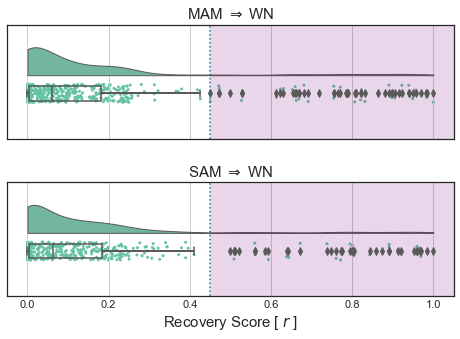

In [45]:
# sam_wn = X_recovery.loc[y_recovery == ("SAM", "WN")].mean(axis=0).sort_values(ascending=False)
# mam_wn = X_recovery.loc[y_recovery == ("MAM", "WN")].mean(axis=0).sort_values(ascending=False)

tol_recoveryscore = 0.45
outliers = set()
with plt.style.context("seaborn-white"):
    fig, axes = plt.subplots(figsize=(8,5), nrows=2, sharex=True, gridspec_kw={"hspace":0.382})
    for j, phenotype_undernourished in enumerate(["MAM", "SAM"]):
        title = "{} $\Rightarrow$ WN".format(phenotype_undernourished)
        data = list()
        for i, u in X_recovery.loc[y_recovery == (phenotype_undernourished, "WN")].iterrows():
            outliers.update(u[lambda x: x > tol_recoveryscore].index.tolist())
            data += u[lambda x: x > 0].tolist()
        data = np.asarray(data)
        pt.RainCloud(x=data, orient="horizontal", ax=axes[j], width_box=0.1618, width_viol=0.618)
        axes[j].set_title(title, fontsize=15)
        q1, q2, q3 = np.percentile(data, [25, 50, 75])
        iqr = q3 - q1
        q99 = np.percentile(data, 99)
        print(title, "Q1:",q1, "Q2:",q2,"Q3:",q3, "IQR:",iqr, "Outlier Range:", (1.5*iqr - q1, 1.5*iqr + q3))
    pad = 0.2
    for ax in axes:
        ax.xaxis.grid(True)
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        ax.axvline(tol_recoveryscore, color="teal", linestyle=":")
        ax.fill_between([tol_recoveryscore, max(xlims)], ylims[0], ylims[1]-pad, color="purple", linestyle=":", alpha=0.1618)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims[0], ylims[1]-pad)
    axes[1].set_xlabel("Recovery Score [ $r$ ]", fontsize=15)

x_recovery = X_recovery.stack()[lambda x: x > 0]
x_recovery[lambda r: r > np.percentile(x_recovery, 99)].sort_values(ascending=False)
# ds_otus.m1.loc["Otu000150"]


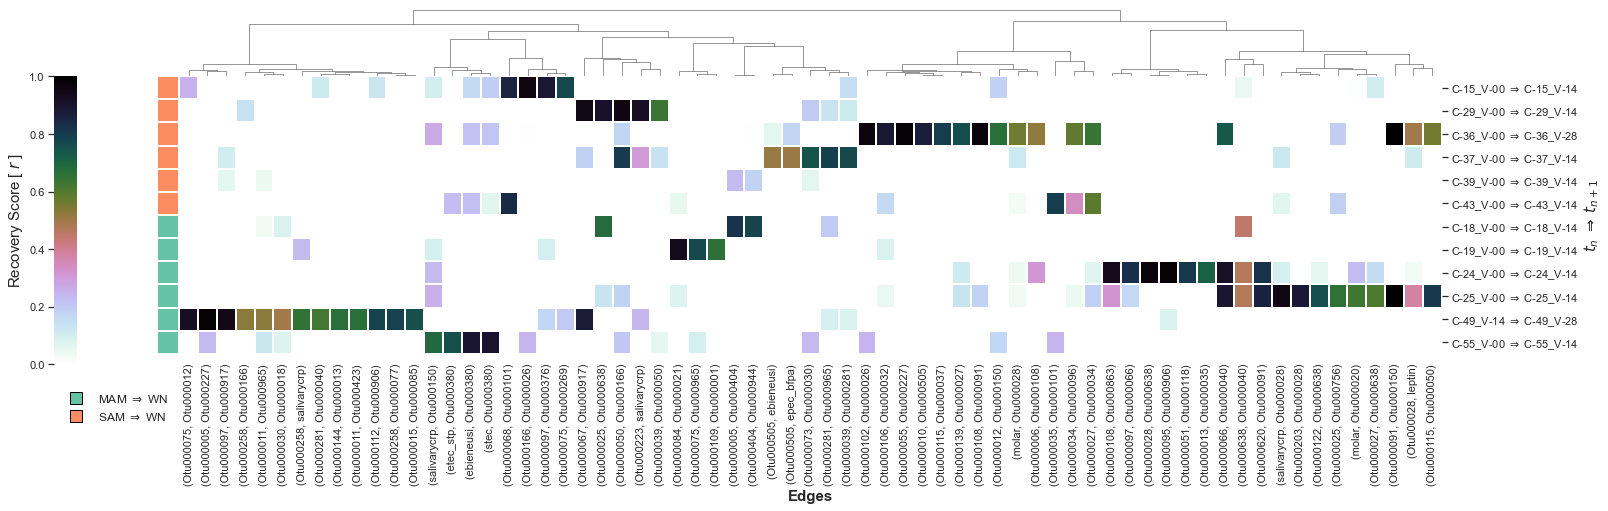

In [46]:

g = sns.clustermap(
    data=X_recovery.loc[:,outliers], 
    method="ward", 
    vmin=0, vmax=1, cmap=cmap, 
    figsize=(21,8), 
    dendrogram_ratio=(0.05, 0.2), 
    colors_ratio=0.01618,
    linewidth=1, edgecolor="white", 
    xticklabels=True,
    cbar_pos=[-0.01618, 0.36, 0.015, 0.5],
    row_colors=y_recovery[X_recovery.index].map(lambda x: colors_status.class_colors[x[0]]),
    row_cluster=False,
    
)
g.ax_heatmap.set_xticklabels(map(lambda tick:"({}, {})".format(*list(eval(tick.get_text()))), g.ax_heatmap.get_xticklabels()))
# g.ax_heatmap.set_yticklabels(map(lambda ticklabel:"{} $\Rightarrow$ {}".format(*ticklabel.split("_"), list(map(lambda tick: tick.get_text(), g.ax_heatmap.get_yticklabels()))))

g.ax_heatmap.set_yticklabels(map(lambda ticklabel:"{} $\Rightarrow$ {}".format(*ticklabel), X_recovery.index))

X_recovery.index
g.ax_heatmap.set_ylabel("{} $\Rightarrow$ {}".format(*g.ax_heatmap.get_ylabel().split("-")), fontsize=15, fontweight="bold")
g.ax_heatmap.set_xlabel("Edges", fontsize=15, fontweight="bold")
g.cax.yaxis.set_ticks_position('left')
g.cax.set_ylabel("Recovery Score [ $r$ ]", fontsize=15)#, fontweight="bold", loc="center")
g.cax.yaxis.set_label_position("left")
legend = colors_status.class_colors[["MAM", "SAM"]]
legend.index = legend.index.map(lambda c: "{} $\Rightarrow$ WN".format(c))
g.ax_heatmap.legend(*sy.utils.format_mpl_legend_handles(legend), bbox_to_anchor=(0, -0.1), markerscale=2, fontsize=12)
# g.cax.set_visible(True)
# sy.utils.add_cbar_from_data(g.fig, cmap, vmin=0, vmax=1, cbar_pos=[-0.01, 0.1, 0.015, 0.8])


# list(map(lambda tick:tick.get_text(), g.ax_heatmap.get_xticklabels()))

In [47]:
print("Total duration:", sy.utils.format_duration(start_time))
print("MacBook Pro (16-inch, 2019) 2.3 GHz 8-Core Intel Core i9")

Total duration: 00:05:39
MacBook Pro (16-inch, 2019) 2.3 GHz 8-Core Intel Core i9
